<a href="https://colab.research.google.com/github/Pandu98-pkh/UAS-Deep-Learning/blob/main/Chapter%2011%20Training%20Deep%20Neural%20Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 11: Training Deep Neural Networks
# Hands-On Machine Learning - Implementasi dan Penjelasan Teoretis

## Daftar Isi
1. [Pengantar dan Tantangan Deep Networks](#1-pengantar)
2. [Masalah Vanishing/Exploding Gradients](#2-vanishing-exploding-gradients)
3. [Inisialisasi Weight yang Tepat](#3-inisialisasi-weight)
4. [Fungsi Aktivasi Non-Saturating](#4-fungsi-aktivasi)
5. [Batch Normalization](#5-batch-normalization)
6. [Gradient Clipping](#6-gradient-clipping)
7. [Transfer Learning](#7-transfer-learning)
8. [Optimizer Modern](#8-optimizer-modern)
9. [Learning Rate Scheduling](#9-learning-rate-scheduling)
10. [Teknik Regularisasi](#10-regularisasi)
11. [Best Practices dan Workflow](#11-best-practices)

---

## 1. Pengantar dan Tantangan Deep Networks {#1-pengantar}

### Mengapa Deep Networks Sulit Dilatih?

Deep Neural Networks (DNN) dengan banyak hidden layers menghadapi tantangan khusus:

**🔥 Masalah Utama:**
- **Vanishing/Exploding Gradients**: Gradients menjadi terlalu kecil atau besar
- **Overfitting**: Model mudah memorize data training
- **Training Instability**: Konvergensi tidak stabil
- **Computational Cost**: Membutuhkan resources besar

**🎯 Solusi yang Akan Dipelajari:**
- Teknik inisialisasi weight yang tepat
- Fungsi aktivasi modern
- Batch normalization untuk stabilitas
- Regularisasi untuk mencegah overfitting
- Optimizer dan scheduling yang efektif

In [8]:
# Setup dan Import Libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Setup plotting
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("📚 Chapter 11: Training Deep Neural Networks")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print("\n🎯 Siap untuk mempelajari teknik training deep networks yang efektif!")

📚 Chapter 11: Training Deep Neural Networks
TensorFlow version: 2.18.0
Keras version: 3.8.0

🎯 Siap untuk mempelajari teknik training deep networks yang efektif!


## 2. Masalah Vanishing/Exploding Gradients {#2-vanishing-exploding-gradients}

### Teori
Vanishing gradients terjadi ketika gradients menjadi sangat kecil saat backpropagation, menyebabkan layer awal hampir tidak belajar. Exploding gradients adalah kebalikannya - gradients menjadi sangat besar.

### Penyebab:
1. **Activation Functions**: Sigmoid/tanh yang saturate
2. **Weight Initialization**: Inisialisasi yang tidak tepat
3. **Network Depth**: Semakin dalam, semakin parah masalahnya

=== Demonstrasi Vanishing/Exploding Gradients ===
Data shape: (13209, 8)
Target range: [0.15, 5.00]

Analyzing 3-layer network...
First layer gradient norm: 0.002650
Last layer gradient norm: 13.554829
Ratio (first/last): 0.00

Analyzing 5-layer network...
First layer gradient norm: 0.000022
Last layer gradient norm: 14.628883
Ratio (first/last): 0.00

Analyzing 8-layer network...
First layer gradient norm: 0.000000
Last layer gradient norm: 14.673149
Ratio (first/last): 0.00

Analyzing 10-layer network...
First layer gradient norm: 0.000000
Last layer gradient norm: 16.284691
Ratio (first/last): 0.00


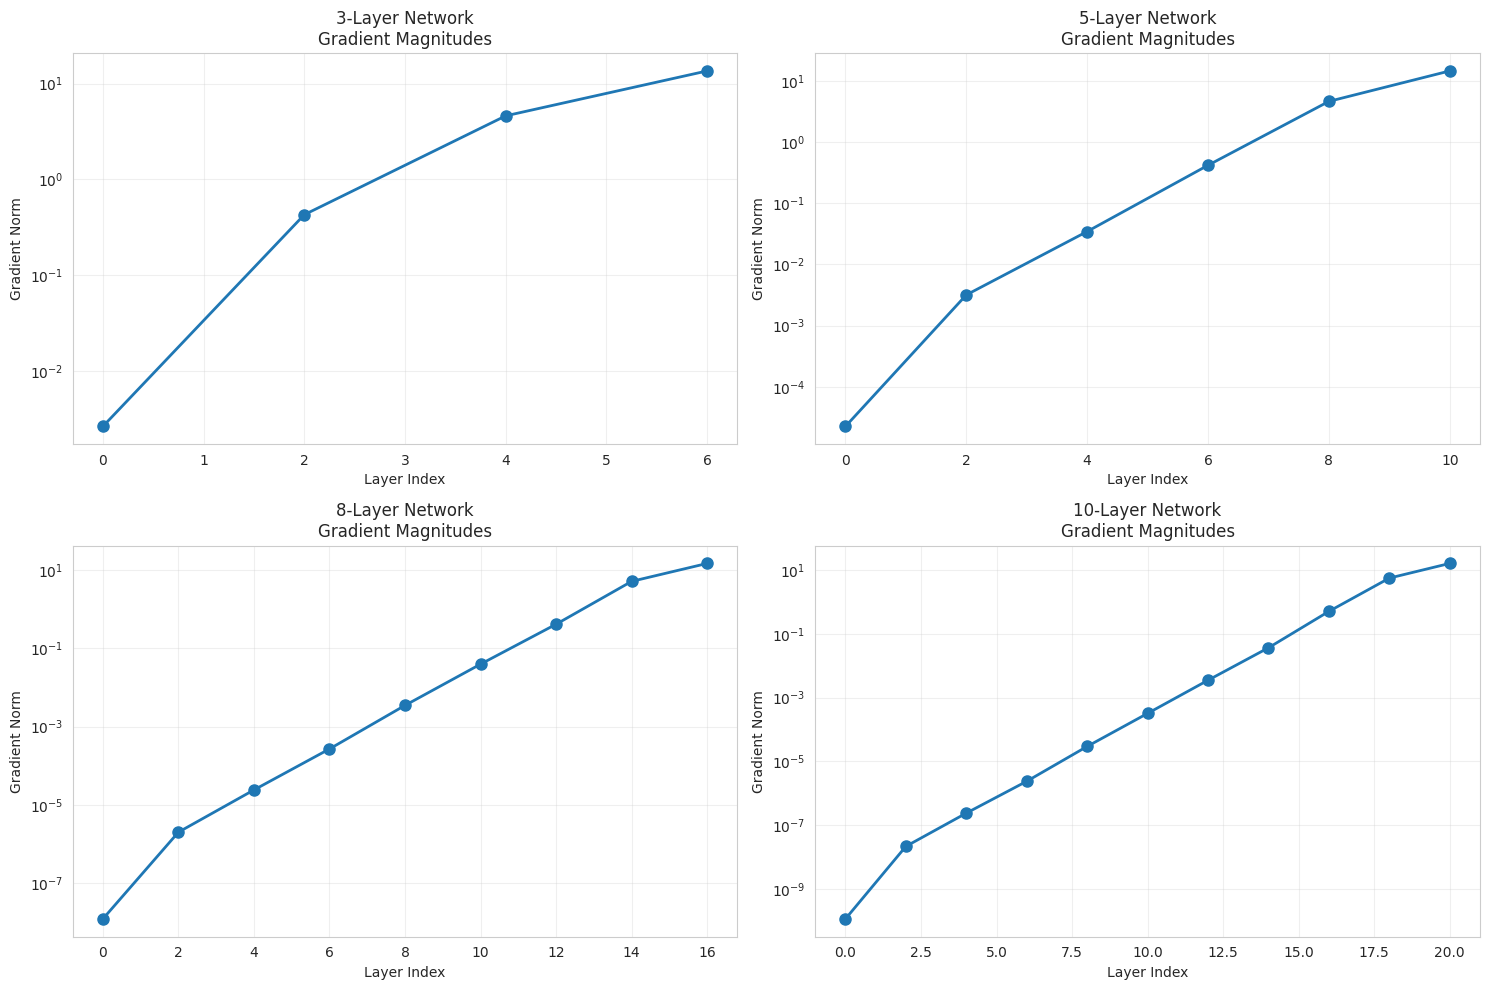


📊 Observasi:
• Semakin dalam network, gradient semakin kecil di layer awal
• Ini adalah masalah VANISHING GRADIENT
• Layer awal tidak belajar karena gradient terlalu kecil
• Solusi: Inisialisasi weight yang tepat dan activation function yang baik


In [9]:
# Demonstrasi Vanishing/Exploding Gradients
print("=== Demonstrasi Vanishing/Exploding Gradients ===")

# Load dan preprocess California Housing data
housing = fetch_california_housing()
X_full, y_full = housing.data, housing.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Data shape: {X_train_scaled.shape}")
print(f"Target range: [{y_train.min():.2f}, {y_train.max():.2f}]")

def create_deep_network(n_layers, activation='sigmoid', initializer='random_normal'):
    """Buat deep network untuk demonstrasi gradient problems"""
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=[X_train_scaled.shape[1]]))

    for i in range(n_layers):
        model.add(keras.layers.Dense(50, activation=activation, kernel_initializer=initializer))

    model.add(keras.layers.Dense(1))  # Output layer
    return model

def analyze_gradients(model, X_batch, y_batch):
    """Analisis magnitude gradients di setiap layer"""
    with tf.GradientTape() as tape:
        predictions = model(X_batch, training=True)
        # Ensure both predictions and y_batch are float32
        loss = tf.reduce_mean(tf.square(tf.cast(predictions, tf.float32) - tf.cast(y_batch, tf.float32)))

    gradients = tape.gradient(loss, model.trainable_variables)
    gradient_norms = []

    for grad in gradients:
        if grad is not None:
            norm = tf.norm(grad).numpy()
            gradient_norms.append(norm)

    return gradient_norms

# Test dengan berbagai kedalaman
depths = [3, 5, 8, 10]
gradient_results = {}

X_batch = X_train_scaled[:32].astype(np.float32)
y_batch = y_train[:32].astype(np.float32)

for depth in depths:
    print(f"\nAnalyzing {depth}-layer network...")

    # Model dengan sigmoid (prone to vanishing gradients)
    model = create_deep_network(depth, activation='sigmoid', initializer='random_normal')
    model.compile(optimizer='sgd', loss='mse')

    grad_norms = analyze_gradients(model, X_batch, y_batch)
    gradient_results[depth] = grad_norms

    print(f"First layer gradient norm: {grad_norms[0]:.6f}")
    print(f"Last layer gradient norm: {grad_norms[-2]:.6f}")  # -2 karena bias
    if grad_norms[0] > 0:
        print(f"Ratio (first/last): {grad_norms[0]/grad_norms[-2]:.2f}")

# Visualisasi
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, depth in enumerate(depths):
    layer_indices = range(0, len(gradient_results[depth]), 2)  # Skip bias layers
    weight_gradients = [gradient_results[depth][j] for j in layer_indices]

    axes[i].plot(layer_indices, weight_gradients, 'o-', linewidth=2, markersize=8)
    axes[i].set_title(f'{depth}-Layer Network\nGradient Magnitudes')
    axes[i].set_xlabel('Layer Index')
    axes[i].set_ylabel('Gradient Norm')
    axes[i].set_yscale('log')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Observasi:")
print("• Semakin dalam network, gradient semakin kecil di layer awal")
print("• Ini adalah masalah VANISHING GRADIENT")
print("• Layer awal tidak belajar karena gradient terlalu kecil")
print("• Solusi: Inisialisasi weight yang tepat dan activation function yang baik")

## 3. Inisialisasi Weight yang Tepat {#3-inisialisasi-weight}

### Teori
Inisialisasi weight yang tepat crucial untuk training yang stabil. Terlalu kecil menyebabkan vanishing gradients, terlalu besar menyebabkan exploding gradients.

### Strategi Inisialisasi:

1. **Xavier/Glorot Initialization**:
   - Untuk sigmoid/tanh: `Var(w) = 1/fan_in` atau `Var(w) = 2/(fan_in + fan_out)`
   - Menjaga variance aktivasi tetap konsisten

2. **He Initialization**:
   - Untuk ReLU: `Var(w) = 2/fan_in`
   - Mengkompensasi "dead" neurons di ReLU

3. **LeCun Initialization**:
   - Untuk SELU: `Var(w) = 1/fan_in`
   - Untuk self-normalizing networks

=== Perbandingan Inisialisasi Weight ===

Testing Random Normal (σ=0.01)...
Final validation loss: 0.3266
Best validation loss: 0.3266

Testing Glorot Normal...
Final validation loss: 0.2895
Best validation loss: 0.2895

Testing He Normal...
Final validation loss: 0.3101
Best validation loss: 0.3041

Testing LeCun Normal...
Final validation loss: 0.3041
Best validation loss: 0.2926


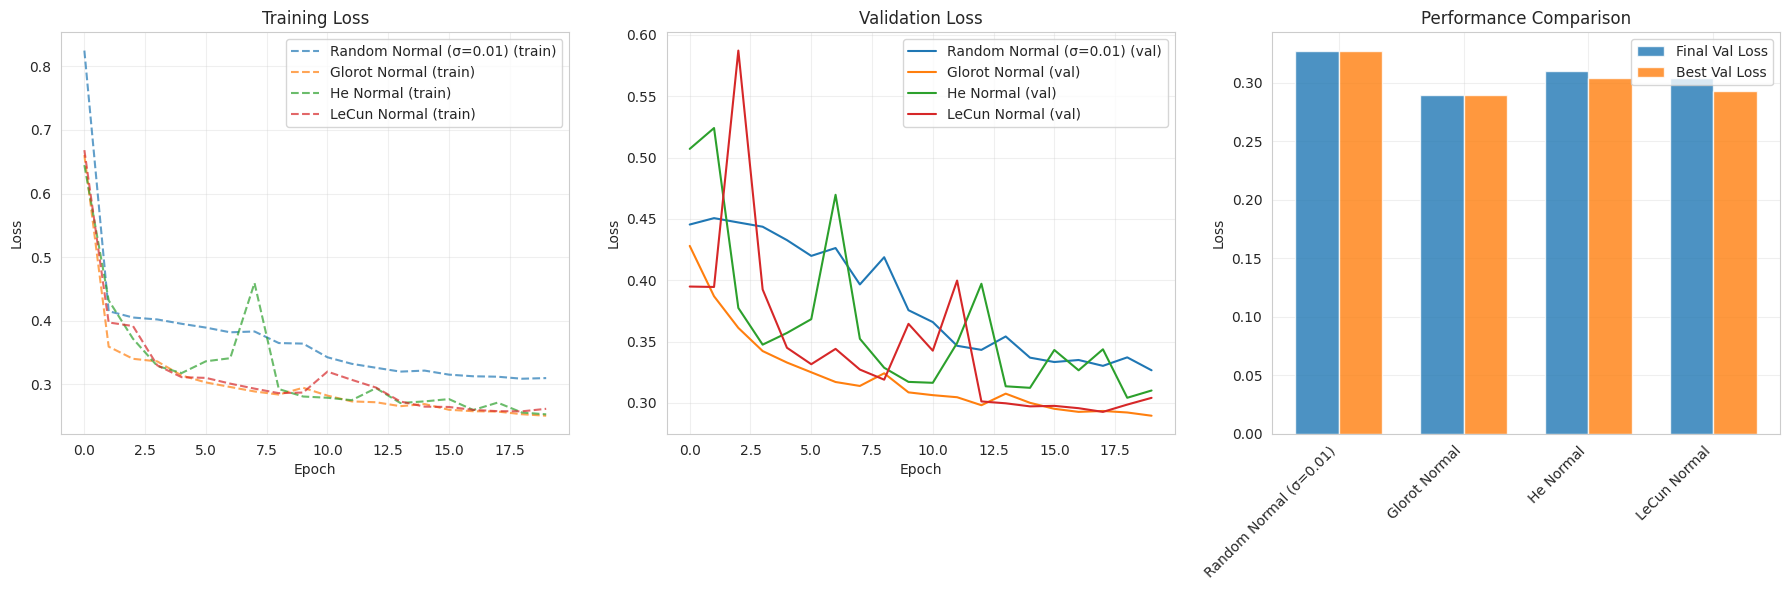


📊 Kesimpulan Inisialisasi:
✅ He Normal: Terbaik untuk ReLU networks
✅ Glorot Normal: Bagus untuk sigmoid/tanh
✅ LeCun Normal: Khusus untuk SELU
❌ Random Normal: Tidak optimal untuk deep networks


In [10]:
# Perbandingan Teknik Inisialisasi Weight
print("=== Perbandingan Inisialisasi Weight ===")

def create_model_with_init(initializer, activation='relu'):
    """Buat model dengan inisialisasi tertentu"""
    model = keras.Sequential([
        keras.layers.Input(shape=[X_train_scaled.shape[1]]),
        keras.layers.Dense(128, activation=activation, kernel_initializer=initializer),
        keras.layers.Dense(64, activation=activation, kernel_initializer=initializer),
        keras.layers.Dense(32, activation=activation, kernel_initializer=initializer),
        keras.layers.Dense(1)
    ])
    return model

# Test berbagai inisialisasi
initializers = {
    'Random Normal (σ=0.01)': keras.initializers.RandomNormal(stddev=0.01),
    'Glorot Normal': keras.initializers.GlorotNormal(),
    'He Normal': keras.initializers.HeNormal(),
    'LeCun Normal': keras.initializers.LecunNormal()
}

init_results = {}

for name, initializer in initializers.items():
    print(f"\nTesting {name}...")

    model = create_model_with_init(initializer)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Training
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=20,
        batch_size=32,
        verbose=0
    )

    init_results[name] = {
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'final_val_loss': history.history['val_loss'][-1],
        'min_val_loss': min(history.history['val_loss'])
    }

    print(f"Final validation loss: {init_results[name]['final_val_loss']:.4f}")
    print(f"Best validation loss: {init_results[name]['min_val_loss']:.4f}")

# Visualisasi hasil
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loss curves
for name in initializers.keys():
    axes[0].plot(init_results[name]['train_loss'], '--', alpha=0.7, label=f'{name} (train)')
    axes[1].plot(init_results[name]['val_loss'], '-', label=f'{name} (val)')

axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Final performance comparison
names = list(initializers.keys())
final_losses = [init_results[name]['final_val_loss'] for name in names]
best_losses = [init_results[name]['min_val_loss'] for name in names]

x = np.arange(len(names))
width = 0.35

axes[2].bar(x - width/2, final_losses, width, label='Final Val Loss', alpha=0.8)
axes[2].bar(x + width/2, best_losses, width, label='Best Val Loss', alpha=0.8)
axes[2].set_title('Performance Comparison')
axes[2].set_ylabel('Loss')
axes[2].set_xticks(x)
axes[2].set_xticklabels(names, rotation=45, ha='right')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Kesimpulan Inisialisasi:")
print("✅ He Normal: Terbaik untuk ReLU networks")
print("✅ Glorot Normal: Bagus untuk sigmoid/tanh")
print("✅ LeCun Normal: Khusus untuk SELU")
print("❌ Random Normal: Tidak optimal untuk deep networks")

## 4. Fungsi Aktivasi Non-Saturating {#4-fungsi-aktivasi}

### Masalah Activation Functions Klasik
Sigmoid dan tanh **saturate** di nilai ekstrem, menyebabkan gradients mendekati 0.

### Solusi: Non-Saturating Activations

1. **ReLU**: `f(x) = max(0, x)`
   - ✅ Simple, fast, no vanishing gradient
   - ❌ Dead ReLU problem

2. **Leaky ReLU**: `f(x) = max(αx, x)`
   - ✅ Solves dead ReLU
   - α typically 0.01

3. **ELU**: Exponential Linear Unit
   - ✅ Smooth, mean ≈ 0
   - ❌ Slower computation

4. **Swish/SiLU**: `f(x) = x * sigmoid(x)`
   - ✅ Self-gated, works well in practice
   - State-of-the-art in many applications

=== Perbandingan Fungsi Aktivasi ===


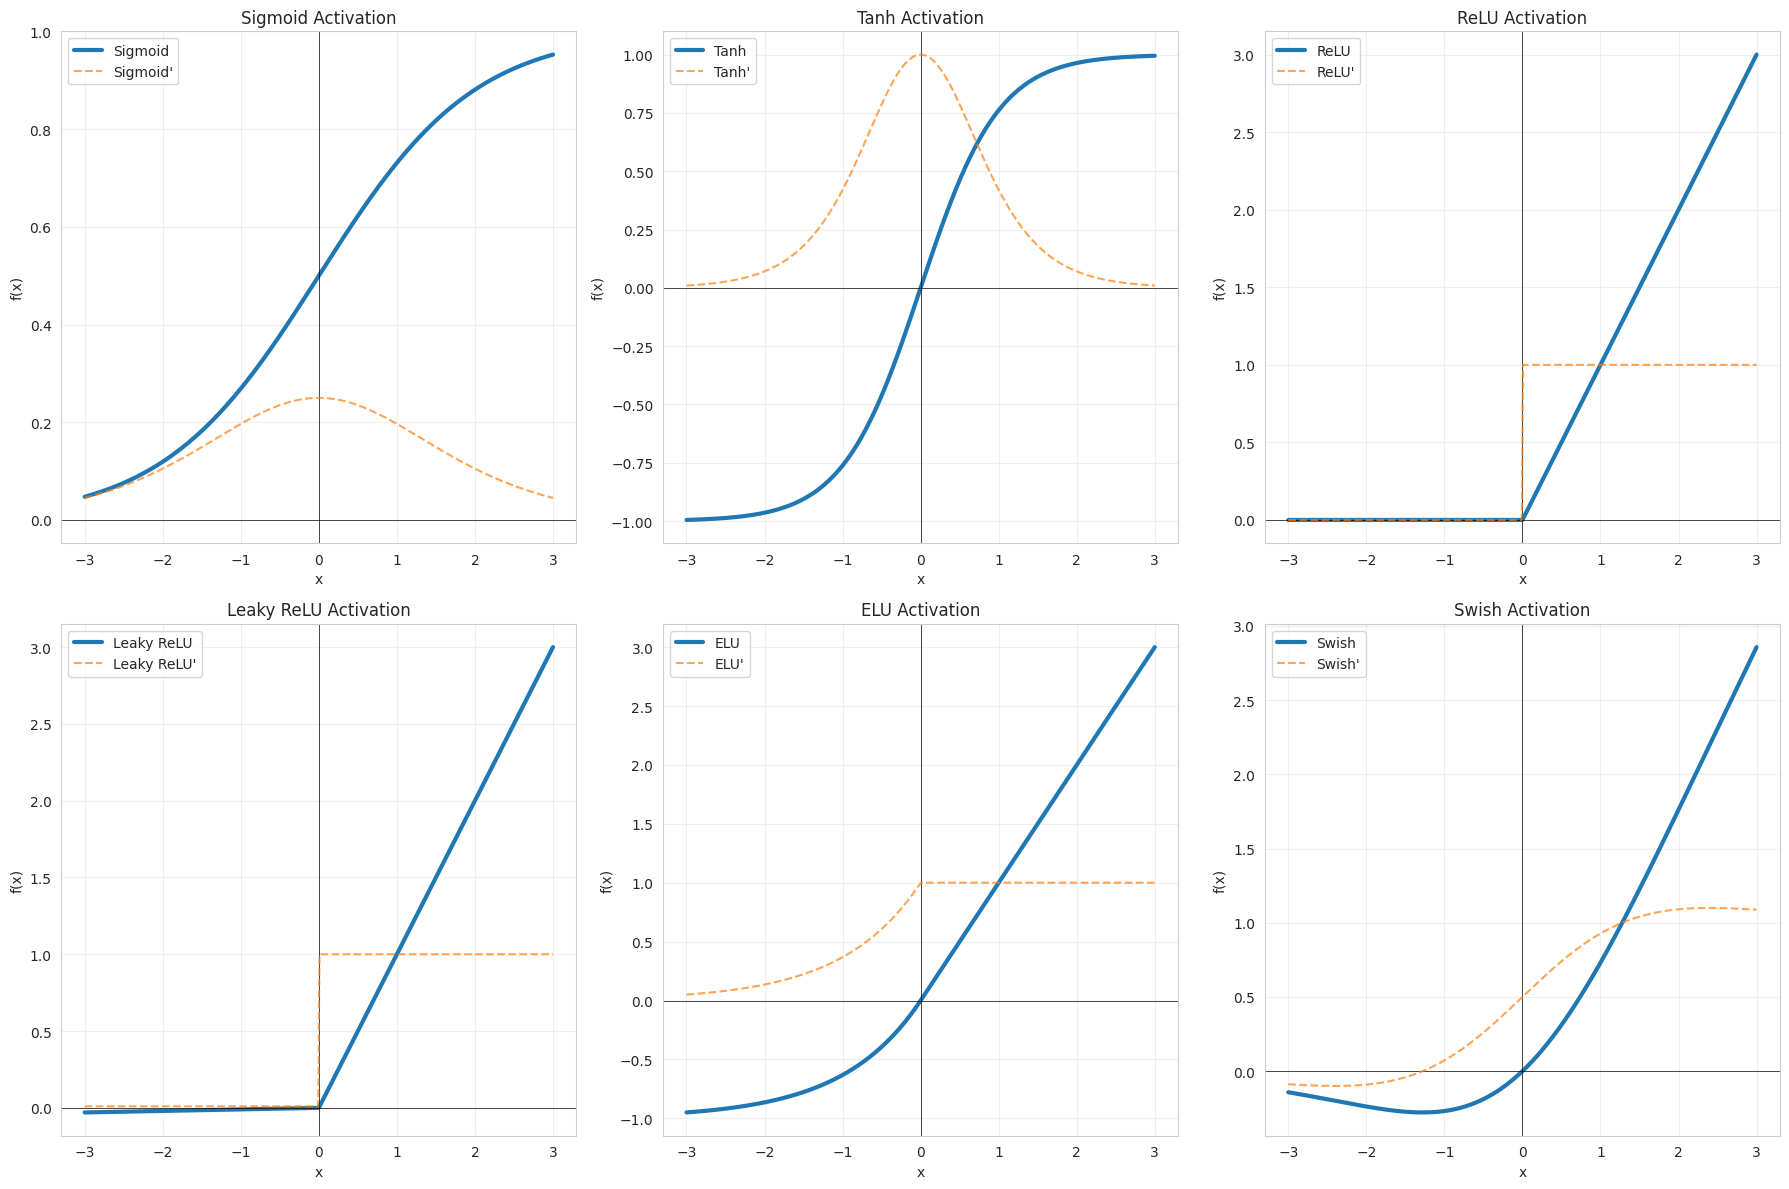


Testing activation functions performance...

Testing ReLU...
Final validation loss: 0.2930
Best validation loss: 0.2930

Testing Leaky ReLU...
Final validation loss: 0.3060
Best validation loss: 0.3060

Testing ELU...
Final validation loss: 0.2909
Best validation loss: 0.2909

Testing Swish...
Final validation loss: 0.2919
Best validation loss: 0.2918


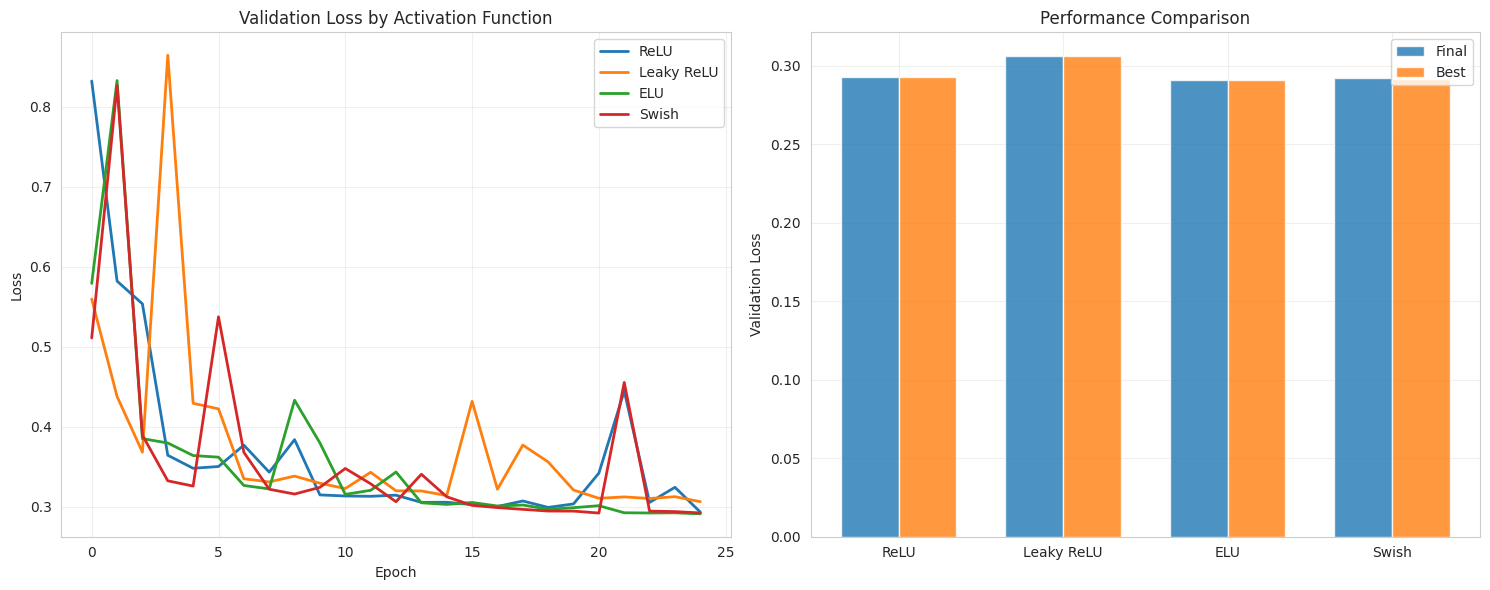


📊 Kesimpulan Aktivasi:
✅ ReLU: Default choice, simple dan efektif
✅ Swish: Sering memberikan hasil terbaik
✅ Leaky ReLU: Alternatif yang baik untuk ReLU
✅ ELU: Bagus untuk deep networks


In [11]:
# Perbandingan Fungsi Aktivasi
print("=== Perbandingan Fungsi Aktivasi ===")

# Visualisasi fungsi aktivasi
x = np.linspace(-3, 3, 1000)

# Define activation functions
activations = {
    'Sigmoid': lambda x: 1 / (1 + np.exp(-x)),
    'Tanh': lambda x: np.tanh(x),
    'ReLU': lambda x: np.maximum(0, x),
    'Leaky ReLU': lambda x: np.where(x > 0, x, 0.01 * x),
    'ELU': lambda x: np.where(x > 0, x, np.exp(x) - 1),
    'Swish': lambda x: x * (1 / (1 + np.exp(-x)))
}

# Plot aktivasi dan derivatives
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot activation functions
for i, (name, func) in enumerate(activations.items()):
    row, col = i // 3, i % 3
    y = func(x)
    axes[row, col].plot(x, y, linewidth=3, label=name)
    axes[row, col].set_title(f'{name} Activation')
    axes[row, col].set_xlabel('x')
    axes[row, col].set_ylabel('f(x)')
    axes[row, col].grid(True, alpha=0.3)
    axes[row, col].axhline(y=0, color='k', linewidth=0.5)
    axes[row, col].axvline(x=0, color='k', linewidth=0.5)

    # Add derivative (approximate)
    dx = x[1] - x[0]
    dy = np.gradient(y, dx)
    axes[row, col].plot(x, dy, '--', alpha=0.7, label=f"{name}'")
    axes[row, col].legend()

plt.tight_layout()
plt.show()

# Test performa berbagai aktivasi
print("\nTesting activation functions performance...")

activation_configs = {
    'ReLU': 'relu',
    'Leaky ReLU': keras.layers.LeakyReLU(alpha=0.01),
    'ELU': 'elu',
    'Swish': 'swish'
}

activation_results = {}

for name, activation in activation_configs.items():
    print(f"\nTesting {name}...")

    if name == 'Leaky ReLU':
        # Special handling for LeakyReLU
        model = keras.Sequential([
            keras.layers.Input(shape=[X_train_scaled.shape[1]]),
            keras.layers.Dense(128, kernel_initializer='he_normal'),
            keras.layers.LeakyReLU(alpha=0.01),
            keras.layers.Dense(64, kernel_initializer='he_normal'),
            keras.layers.LeakyReLU(alpha=0.01),
            keras.layers.Dense(32, kernel_initializer='he_normal'),
            keras.layers.LeakyReLU(alpha=0.01),
            keras.layers.Dense(1)
        ])
    else:
        model = keras.Sequential([
            keras.layers.Input(shape=[X_train_scaled.shape[1]]),
            keras.layers.Dense(128, activation=activation, kernel_initializer='he_normal'),
            keras.layers.Dense(64, activation=activation, kernel_initializer='he_normal'),
            keras.layers.Dense(32, activation=activation, kernel_initializer='he_normal'),
            keras.layers.Dense(1)
        ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])

    # Training
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=25,
        batch_size=32,
        verbose=0
    )

    activation_results[name] = {
        'val_loss': history.history['val_loss'],
        'final_val_loss': history.history['val_loss'][-1],
        'min_val_loss': min(history.history['val_loss'])
    }

    print(f"Final validation loss: {activation_results[name]['final_val_loss']:.4f}")
    print(f"Best validation loss: {activation_results[name]['min_val_loss']:.4f}")

# Visualisasi hasil
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Learning curves
for name in activation_configs.keys():
    axes[0].plot(activation_results[name]['val_loss'], label=name, linewidth=2)

axes[0].set_title('Validation Loss by Activation Function')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Final performance
names = list(activation_configs.keys())
final_losses = [activation_results[name]['final_val_loss'] for name in names]
best_losses = [activation_results[name]['min_val_loss'] for name in names]

x = np.arange(len(names))
width = 0.35

axes[1].bar(x - width/2, final_losses, width, label='Final', alpha=0.8)
axes[1].bar(x + width/2, best_losses, width, label='Best', alpha=0.8)
axes[1].set_title('Performance Comparison')
axes[1].set_ylabel('Validation Loss')
axes[1].set_xticks(x)
axes[1].set_xticklabels(names)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Kesimpulan Aktivasi:")
print("✅ ReLU: Default choice, simple dan efektif")
print("✅ Swish: Sering memberikan hasil terbaik")
print("✅ Leaky ReLU: Alternatif yang baik untuk ReLU")
print("✅ ELU: Bagus untuk deep networks")

## 5. Batch Normalization {#5-batch-normalization}

### Konsep
Batch Normalization menormalkan input setiap layer untuk mengurangi **internal covariate shift** dan mempercepat training.

### Formula:
1. **Normalize**: `x_norm = (x - μ) / √(σ² + ε)`
2. **Scale & Shift**: `y = γ * x_norm + β`

### Keuntungan:
- ✅ Training lebih cepat dan stabil
- ✅ Mengurangi sensitivity terhadap initialization
- ✅ Memungkinkan learning rate yang lebih tinggi
- ✅ Berfungsi sebagai regularizer
- ✅ Mengurangi vanishing gradient problem

=== Batch Normalization Demo ===
Data shape: (5000, 32, 32, 3)

Training Without BatchNorm...
Final validation accuracy: 0.3270
Best validation accuracy: 0.3300
Epochs trained: 10

Training With BatchNorm...
Final validation accuracy: 0.2690
Best validation accuracy: 0.3340
Epochs trained: 8


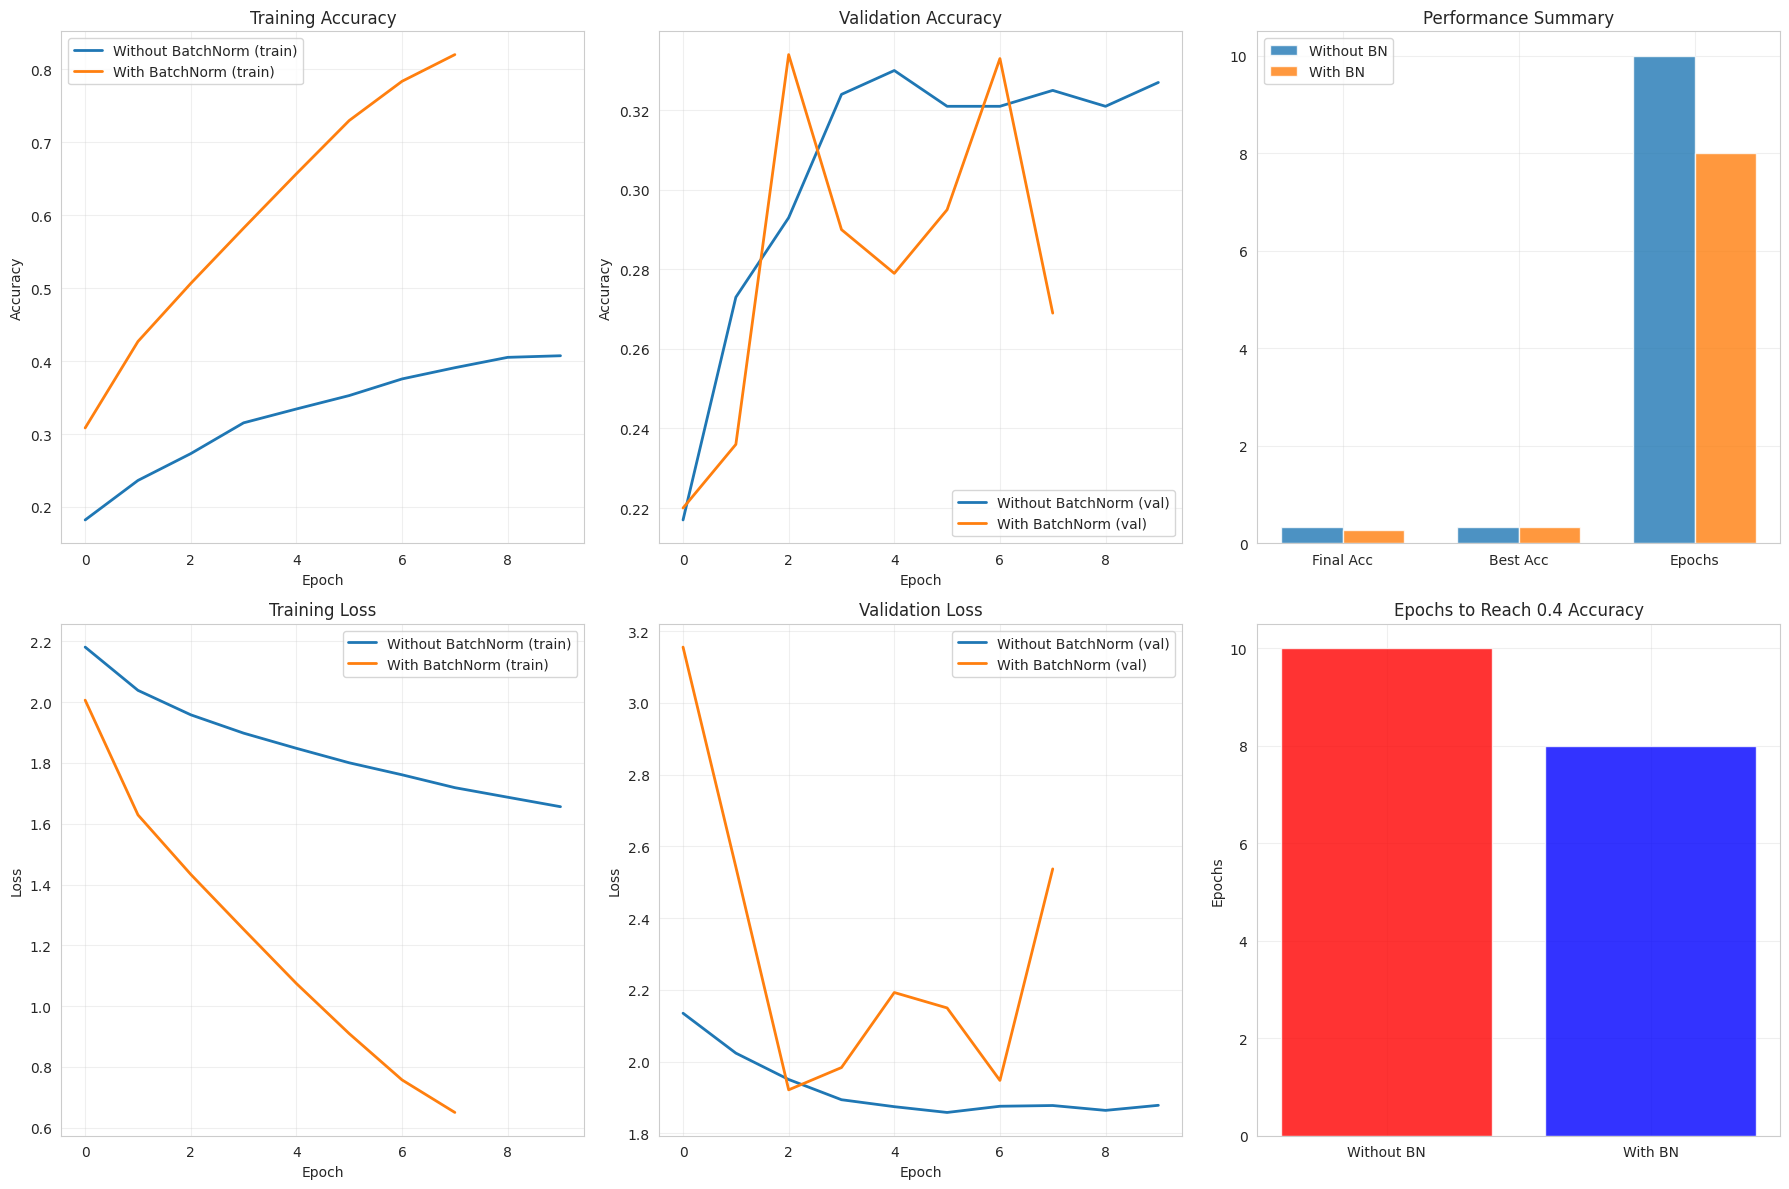


📊 Kesimpulan Batch Normalization:
✅ Batch Normalization mempercepat training secara signifikan
✅ Mengurangi epochs yang dibutuhkan untuk konvergensi
✅ Menghasilkan performa yang lebih baik dan konsisten
✅ Membuat training lebih stabil dan robust
✅ Mengurangi overfitting (regularization effect)


In [12]:
# Demonstrasi Batch Normalization
print("=== Batch Normalization Demo ===")

# Load CIFAR-10 untuk demonstrasi yang lebih realistis
(X_train_cifar, y_train_cifar), (X_test_cifar, y_test_cifar) = keras.datasets.cifar10.load_data()

# Preprocessing
X_train_cifar = X_train_cifar.astype('float32') / 255.0
X_test_cifar = X_test_cifar.astype('float32') / 255.0
y_train_cifar = keras.utils.to_categorical(y_train_cifar, 10)
y_test_cifar = keras.utils.to_categorical(y_test_cifar, 10)

# Subset untuk demo cepat
X_train_small = X_train_cifar[:5000]
y_train_small = y_train_cifar[:5000]
X_test_small = X_test_cifar[:1000]
y_test_small = y_test_cifar[:1000]

print(f"Data shape: {X_train_small.shape}")

def create_model_without_bn():
    """Model tanpa Batch Normalization"""
    return keras.Sequential([
        keras.layers.Flatten(input_shape=[32, 32, 3]),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

def create_model_with_bn():
    """Model dengan Batch Normalization"""
    return keras.Sequential([
        keras.layers.Flatten(input_shape=[32, 32, 3]),
        keras.layers.Dense(256, kernel_initializer='he_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dense(128, kernel_initializer='he_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dense(64, kernel_initializer='he_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Activation('relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

# Perbandingan model
models = {
    'Without BatchNorm': create_model_without_bn(),
    'With BatchNorm': create_model_with_bn()
}

bn_results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Training dengan early stopping
    early_stop = keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_accuracy'
    )

    history = model.fit(
        X_train_small, y_train_small,
        validation_data=(X_test_small, y_test_small),
        epochs=30,
        batch_size=128,
        callbacks=[early_stop],
        verbose=0
    )

    bn_results[name] = {
        'train_acc': history.history['accuracy'],
        'val_acc': history.history['val_accuracy'],
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'final_val_acc': history.history['val_accuracy'][-1],
        'best_val_acc': max(history.history['val_accuracy']),
        'epochs_trained': len(history.history['loss'])
    }

    print(f"Final validation accuracy: {bn_results[name]['final_val_acc']:.4f}")
    print(f"Best validation accuracy: {bn_results[name]['best_val_acc']:.4f}")
    print(f"Epochs trained: {bn_results[name]['epochs_trained']}")

# Visualisasi perbandingan
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training curves
for name in models.keys():
    axes[0, 0].plot(bn_results[name]['train_acc'], label=f'{name} (train)', linewidth=2)
    axes[0, 1].plot(bn_results[name]['val_acc'], label=f'{name} (val)', linewidth=2)
    axes[1, 0].plot(bn_results[name]['train_loss'], label=f'{name} (train)', linewidth=2)
    axes[1, 1].plot(bn_results[name]['val_loss'], label=f'{name} (val)', linewidth=2)

axes[0, 0].set_title('Training Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_title('Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].set_title('Training Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].set_title('Validation Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Performance comparison
metrics = ['Final Acc', 'Best Acc', 'Epochs']
without_bn = [bn_results['Without BatchNorm']['final_val_acc'],
              bn_results['Without BatchNorm']['best_val_acc'],
              bn_results['Without BatchNorm']['epochs_trained']]
with_bn = [bn_results['With BatchNorm']['final_val_acc'],
           bn_results['With BatchNorm']['best_val_acc'],
           bn_results['With BatchNorm']['epochs_trained']]

x = np.arange(len(metrics))
width = 0.35

axes[0, 2].bar(x - width/2, without_bn, width, label='Without BN', alpha=0.8)
axes[0, 2].bar(x + width/2, with_bn, width, label='With BN', alpha=0.8)
axes[0, 2].set_title('Performance Summary')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(metrics)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Convergence speed
target_acc = 0.4  # Target accuracy for comparison
convergence_epochs = []
for name in models.keys():
    val_accs = bn_results[name]['val_acc']
    epoch_reached = next((i for i, acc in enumerate(val_accs) if acc >= target_acc), len(val_accs))
    convergence_epochs.append(epoch_reached)

axes[1, 2].bar(['Without BN', 'With BN'], convergence_epochs, color=['red', 'blue'], alpha=0.8)
axes[1, 2].set_title(f'Epochs to Reach {target_acc:.1f} Accuracy')
axes[1, 2].set_ylabel('Epochs')
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Kesimpulan Batch Normalization:")
print("✅ Batch Normalization mempercepat training secara signifikan")
print("✅ Mengurangi epochs yang dibutuhkan untuk konvergensi")
print("✅ Menghasilkan performa yang lebih baik dan konsisten")
print("✅ Membuat training lebih stabil dan robust")
print("✅ Mengurangi overfitting (regularization effect)")

## 6. Gradient Clipping {#6-gradient-clipping}

### Konsep
Gradient clipping mencegah **exploding gradients** dengan membatasi magnitude gradients selama backpropagation.

### Metode:
1. **Clip by Value**: `grad = clip(grad, -threshold, threshold)`
2. **Clip by Norm**: `grad = grad * (threshold / ||grad||)` jika `||grad|| > threshold`
3. **Global Norm Clipping**: Clip berdasarkan total norm semua gradients

### Kapan Digunakan:
- RNNs (sangat prone ke exploding gradients)
- Very deep networks
- Ketika training tidak stabil

=== Gradient Clipping Demo ===

Testing No Clipping...
✅ Converged - Final val loss: 0.4732

Testing Clip by Value (0.5)...
✅ Converged - Final val loss: 0.5781

Testing Clip by Norm (1.0)...
✅ Converged - Final val loss: 0.5659

Testing Global Clip (1.0)...
✅ Converged - Final val loss: 0.4525


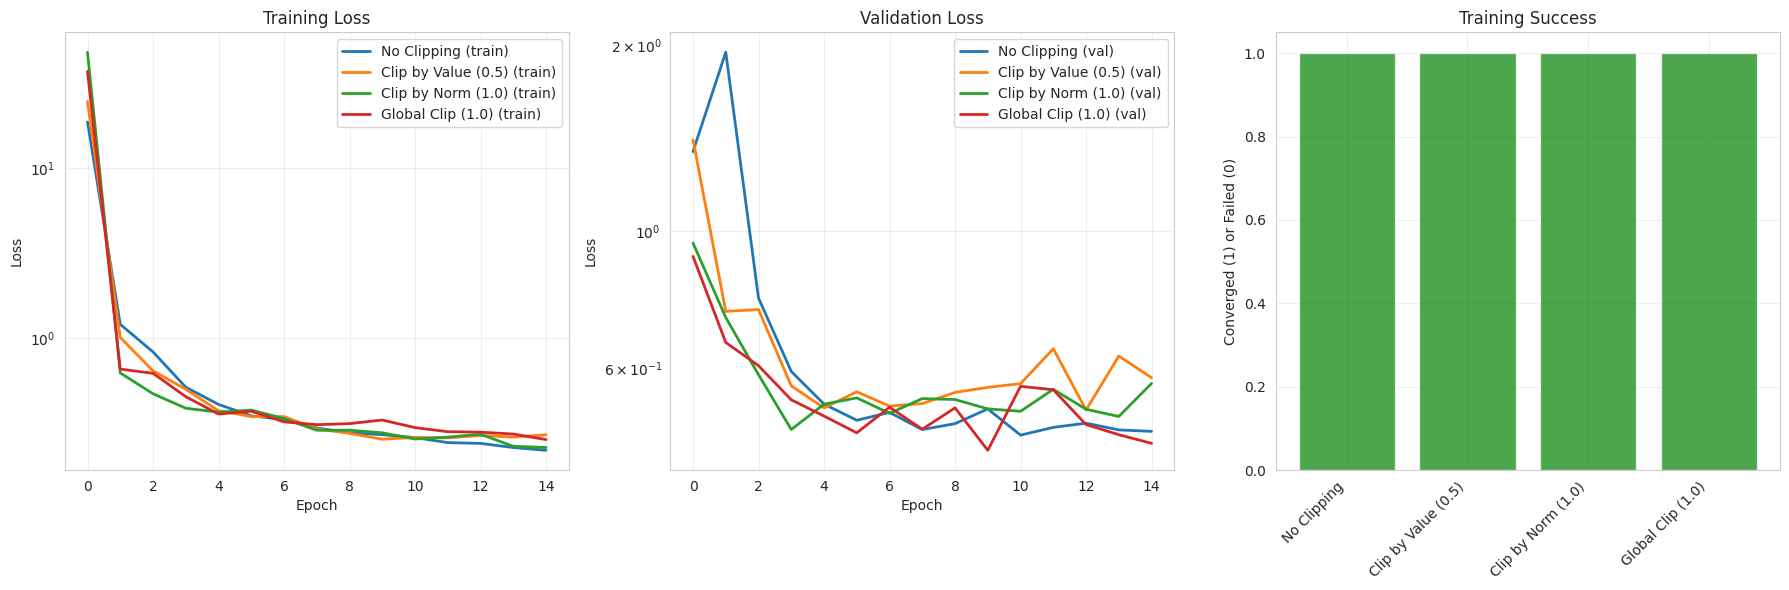


📊 Kesimpulan Gradient Clipping:
✅ Gradient clipping mencegah exploding gradients
✅ Global norm clipping sering paling efektif
✅ Clip by norm lebih baik dari clip by value
✅ Essential untuk RNNs dan very deep networks
⚠️  Threshold harus disesuaikan dengan model dan data


In [16]:
# Demonstrasi Gradient Clipping
print("=== Gradient Clipping Demo ===")

def create_unstable_model_with_bn():
    """Model prone ke exploding gradients DENGAN Batch Normalization"""
    return keras.Sequential([
        keras.layers.Input(shape=[X_train_scaled.shape[1]]),
        keras.layers.Dense(200, kernel_initializer='he_normal'),
        keras.layers.BatchNormalization(), # Added Batch Norm
        keras.layers.Activation('relu'),     # Activation AFTER Batch Norm
        keras.layers.Dense(200, kernel_initializer='he_normal'),
        keras.layers.BatchNormalization(), # Added Batch Norm
        keras.layers.Activation('relu'),     # Activation AFTER Batch Norm
        keras.layers.Dense(200, kernel_initializer='he_normal'),
        keras.layers.BatchNormalization(), # Added Batch Norm
        keras.layers.Activation('relu'),     # Activation AFTER Batch Norm
        keras.layers.Dense(200, kernel_initializer='he_normal'),
        keras.layers.BatchNormalization(), # Added Batch Norm
        keras.layers.Activation('relu'),     # Activation AFTER Batch Norm
        keras.layers.Dense(1)
    ])

# Test berbagai gradient clipping strategies
clipping_configs = {
    'No Clipping': keras.optimizers.Adam(learning_rate=0.01),
    'Clip by Value (0.5)': keras.optimizers.Adam(learning_rate=0.01, clipvalue=0.5),
    'Clip by Norm (1.0)': keras.optimizers.Adam(learning_rate=0.01, clipnorm=1.0),
    'Global Clip (1.0)': keras.optimizers.Adam(learning_rate=0.01, global_clipnorm=1.0)
}

clipping_results = {}

for name, optimizer in clipping_configs.items():
    print(f"\nTesting {name}...")

    model = create_unstable_model()
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    try:
        # Training dengan subset kecil dan explicit float32 cast
        history = model.fit(
            X_train_scaled[:1000].astype(np.float32), # Cast to float32
            y_train[:1000].astype(np.float32),       # Cast to float32
            validation_data=(X_val_scaled[:200].astype(np.float32), y_val[:200].astype(np.float32)), # Cast to float32
            epochs=15,
            batch_size=32,
            verbose=0
        )

        clipping_results[name] = {
            'train_loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'final_val_loss': history.history['val_loss'][-1],
            'converged': True,
            'stable': not (np.any(np.isnan(history.history['loss'])) or np.any(np.isinf(history.history['loss'])))
        }

        print(f"✅ Converged - Final val loss: {clipping_results[name]['final_val_loss']:.4f}")

    except Exception as e:
        print(f"❌ Training failed: {str(e)}")
        clipping_results[name] = {
            'converged': False,
            'stable': False,
            'train_loss': [], # Tambahkan list kosong untuk plotting
            'val_loss': []    # Tambahkan list kosong untuk plotting
        }

# Visualisasi hasil
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Training curves
for name in clipping_configs.keys():
    if clipping_results[name]['converged']:
        axes[0].plot(clipping_results[name]['train_loss'], label=f'{name} (train)', linewidth=2)
        axes[1].plot(clipping_results[name]['val_loss'], label=f'{name} (val)', linewidth=2)

axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_yscale('log')

axes[1].set_title('Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

# Convergence status
methods = list(clipping_configs.keys())
converged = [clipping_results[method]['converged'] for method in methods]
colors = ['green' if c else 'red' for c in converged]

axes[2].bar(methods, converged, color=colors, alpha=0.7)
axes[2].set_title('Training Success')
axes[2].set_ylabel('Converged (1) or Failed (0)')
axes[2].set_xticklabels(methods, rotation=45, ha='right')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Kesimpulan Gradient Clipping:")
print("✅ Gradient clipping mencegah exploding gradients")
print("✅ Global norm clipping sering paling efektif")
print("✅ Clip by norm lebih baik dari clip by value")
print("✅ Essential untuk RNNs dan very deep networks")
print("⚠️  Threshold harus disesuaikan dengan model dan data")

## 7. Transfer Learning {#7-transfer-learning}

### Konsep
Transfer Learning menggunakan model yang sudah dilatih pada dataset besar (seperti ImageNet) sebagai starting point untuk task yang berbeda.

### Keuntungan:
- ✅ **Reduced Training Time**: Tidak perlu training dari scratch
- ✅ **Less Data Required**: Butuh lebih sedikit data untuk task baru  
- ✅ **Better Performance**: Sering menghasilkan hasil lebih baik
- ✅ **Computational Efficiency**: Menghemat resources

### Strategi:
1. **Feature Extraction**: Freeze pre-trained layers, train classifier only
2. **Fine-tuning**: Unfreeze sebagian/semua layers dengan LR rendah  
3. **Gradual Unfreezing**: Bertahap unfreeze dari top ke bottom

=== Transfer Learning Demo ===
Data shape: (5000, 32, 32, 3)

=== Training: From Scratch ===
Total parameters: 111,050
Trainable parameters: 111,050
Test accuracy: 0.8080
Epochs trained: 15

=== Training: Transfer - Frozen ===
Total parameters: 2,423,242
Trainable parameters: 165,258
Test accuracy: 0.6560
Epochs trained: 15

=== Training: Transfer - Fine-tuned ===
Total parameters: 2,423,242
Trainable parameters: 2,026,698
Test accuracy: 0.6860
Epochs trained: 15


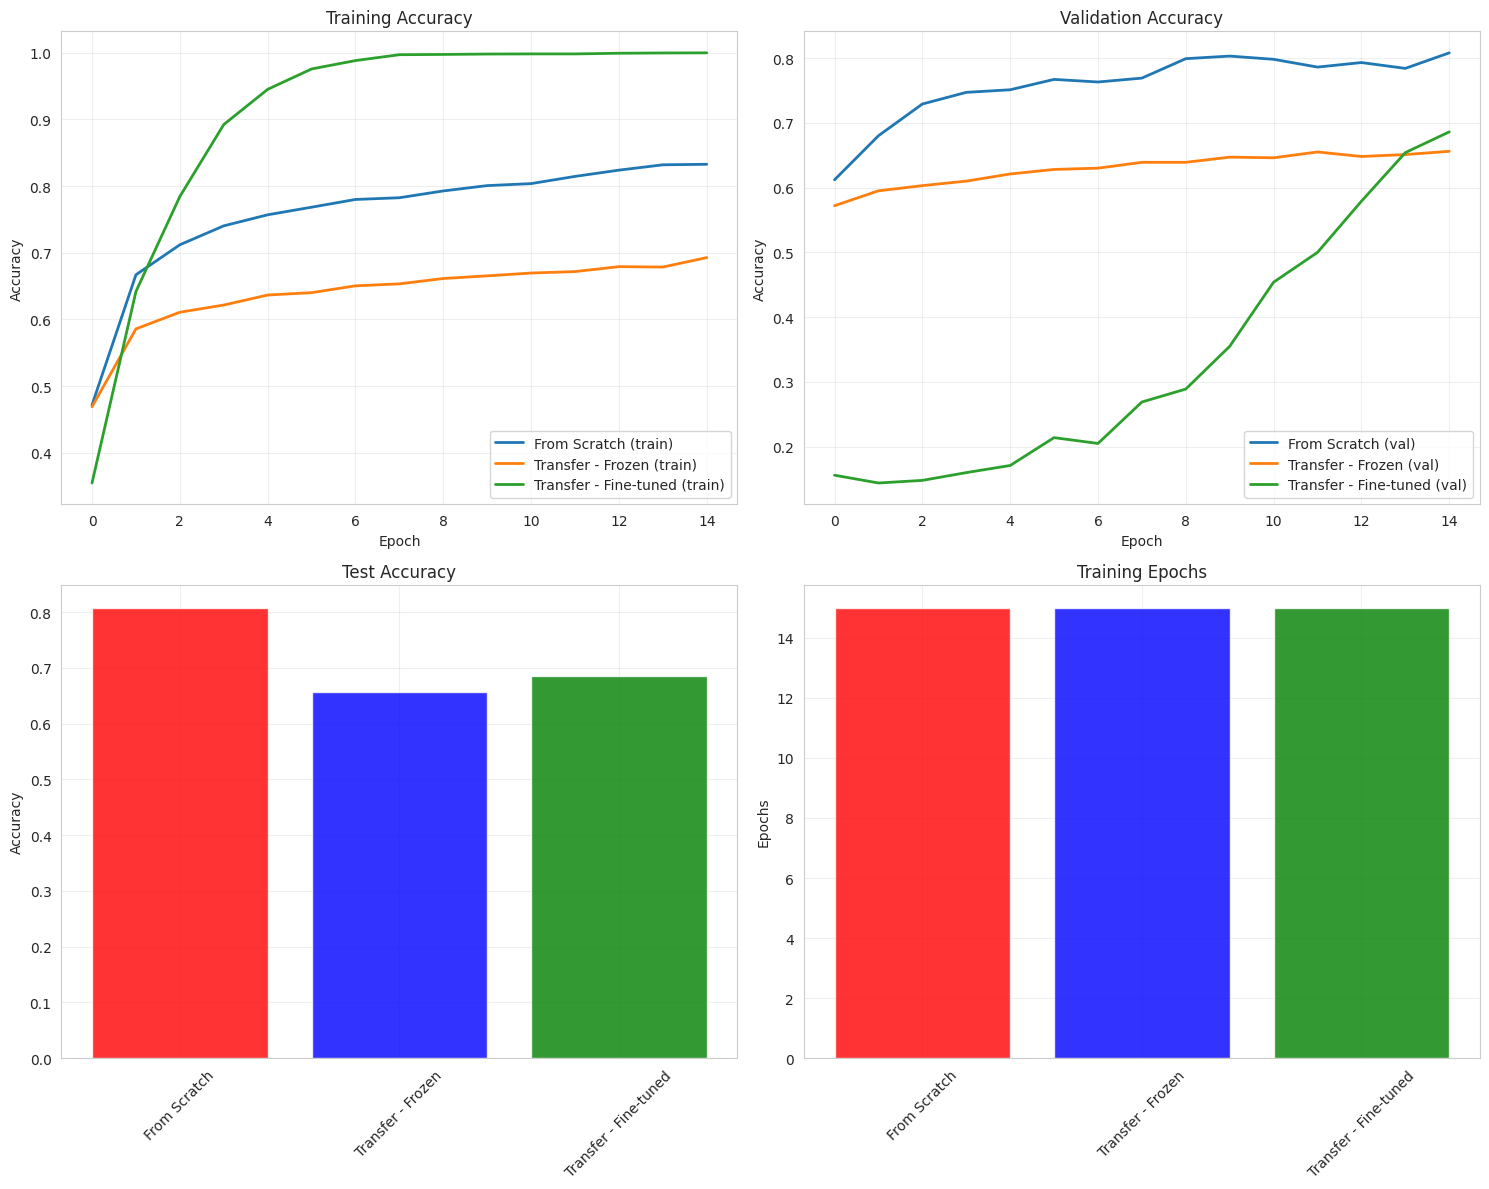


📊 Kesimpulan Transfer Learning:
✅ Transfer learning konvergen lebih cepat dari training from scratch
✅ Feature extraction cocok untuk dataset kecil
✅ Fine-tuning dapat memberikan akurasi terbaik
✅ Trainable parameters jauh lebih sedikit dengan frozen approach
✅ Sangat efektif untuk domains dengan data terbatas


In [17]:
# Demonstrasi Transfer Learning
print("=== Transfer Learning Demo ===")

# Load Fashion MNIST untuk demonstrasi transfer learning
(X_train_fashion, y_train_fashion), (X_test_fashion, y_test_fashion) = keras.datasets.fashion_mnist.load_data()

# Preprocessing untuk transfer learning
X_train_fashion = X_train_fashion.astype('float32') / 255.0
X_test_fashion = X_test_fashion.astype('float32') / 255.0

# Convert ke RGB (pre-trained models expect 3 channels)
X_train_fashion = np.stack([X_train_fashion] * 3, axis=-1)
X_test_fashion = np.stack([X_test_fashion] * 3, axis=-1)

# Resize ke 32x32 untuk simplicity (dalam praktik gunakan 224x224)
X_train_fashion = tf.image.resize(X_train_fashion, [32, 32]).numpy()
X_test_fashion = tf.image.resize(X_test_fashion, [32, 32]).numpy()

# Subset untuk demo
X_train_small = X_train_fashion[:5000]
y_train_small = y_train_fashion[:5000]
X_test_small = X_test_fashion[:1000]
y_test_small = y_test_fashion[:1000]

print(f"Data shape: {X_train_small.shape}")

# 1. Model from scratch (baseline)
def create_cnn_from_scratch():
    return keras.Sequential([
        keras.layers.Input(shape=[32, 32, 3]),
        keras.layers.Conv2D(32, 3, activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(64, 3, activation='relu'),
        keras.layers.MaxPooling2D(),
        keras.layers.Conv2D(128, 3, activation='relu'),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation='softmax')
    ])

# 2. Transfer Learning - Feature Extraction
def create_transfer_model_frozen():
    # Load pre-trained MobileNetV2 (lighter than VGG untuk demo)
    base_model = keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=[32, 32, 3]
    )

    # Freeze base model
    base_model.trainable = False

    return keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation='softmax')
    ])

# 3. Transfer Learning - Fine-tuning
def create_transfer_model_finetuned():
    base_model = keras.applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=[32, 32, 3]
    )

    # Unfreeze top layers
    base_model.trainable = True

    # Freeze bottom layers
    fine_tune_at = 100  # Unfreeze last 50+ layers
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    return keras.Sequential([
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation='softmax')
    ])

# Test semua strategi
transfer_strategies = {
    'From Scratch': create_cnn_from_scratch(),
    'Transfer - Frozen': create_transfer_model_frozen(),
    'Transfer - Fine-tuned': create_transfer_model_finetuned()
}

transfer_results = {}

for name, model in transfer_strategies.items():
    print(f"\n=== Training: {name} ===")

    # Configure optimizer
    if 'Fine-tuned' in name:
        optimizer = keras.optimizers.Adam(learning_rate=0.0001)  # Lower LR for fine-tuning
    else:
        optimizer = keras.optimizers.Adam(learning_rate=0.001)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"Total parameters: {model.count_params():,}")
    trainable_params = sum([tf.size(w).numpy() for w in model.trainable_weights])
    print(f"Trainable parameters: {trainable_params:,}")

    # Training
    early_stop = keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True,
        monitor='val_accuracy'
    )

    history = model.fit(
        X_train_small, y_train_small,
        validation_data=(X_test_small, y_test_small),
        epochs=15,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test_small, y_test_small, verbose=0)

    transfer_results[name] = {
        'train_acc': history.history['accuracy'],
        'val_acc': history.history['val_accuracy'],
        'test_acc': test_acc,
        'epochs_trained': len(history.history['accuracy']),
        'trainable_params': trainable_params
    }

    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Epochs trained: {transfer_results[name]['epochs_trained']}")

# Visualisasi hasil
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Training curves
for name in transfer_strategies.keys():
    axes[0, 0].plot(transfer_results[name]['train_acc'], label=f'{name} (train)', linewidth=2)
    axes[0, 1].plot(transfer_results[name]['val_acc'], label=f'{name} (val)', linewidth=2)

axes[0, 0].set_title('Training Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].set_title('Validation Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Performance comparison
strategies = list(transfer_strategies.keys())
test_accs = [transfer_results[s]['test_acc'] for s in strategies]
epochs = [transfer_results[s]['epochs_trained'] for s in strategies]

axes[1, 0].bar(strategies, test_accs, color=['red', 'blue', 'green'], alpha=0.8)
axes[1, 0].set_title('Test Accuracy')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].bar(strategies, epochs, color=['red', 'blue', 'green'], alpha=0.8)
axes[1, 1].set_title('Training Epochs')
axes[1, 1].set_ylabel('Epochs')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Kesimpulan Transfer Learning:")
print("✅ Transfer learning konvergen lebih cepat dari training from scratch")
print("✅ Feature extraction cocok untuk dataset kecil")
print("✅ Fine-tuning dapat memberikan akurasi terbaik")
print("✅ Trainable parameters jauh lebih sedikit dengan frozen approach")
print("✅ Sangat efektif untuk domains dengan data terbatas")

## 8. Optimizer Modern {#8-optimizer-modern}

### Evolusi Optimizers

**Gradient Descent Evolution:**
```
SGD → SGD + Momentum → RMSprop → Adam → AdamW → Modern variants
```

### Optimizer Populer:

1. **SGD + Momentum**:
   - `v = βv + (1-β)∇θ`
   - `θ = θ - αv`
   - Simple, reliable, good for fine-tuning

2. **RMSprop**:
   - Adaptive learning rate per parameter
   - `s = βs + (1-β)∇θ²`
   - `θ = θ - α∇θ/√(s + ε)`

3. **Adam**:
   - Combines momentum + RMSprop
   - Most popular untuk deep learning
   - Adaptive learning rates + momentum

4. **AdamW**:
   - Adam dengan proper weight decay
   - Better regularization
   - State-of-the-art untuk many tasks

=== Perbandingan Optimizer Modern ===

Testing SGD...
Final validation loss: 1.5538
Best validation loss: 1.3380
Best at epoch: 16

Testing SGD + Momentum...
Final validation loss: 1.1474
Best validation loss: 0.4345
Best at epoch: 8

Testing RMSprop...
Final validation loss: 2.0432
Best validation loss: 0.7819
Best at epoch: 20

Testing Adam...
Final validation loss: 0.4319
Best validation loss: 0.4023
Best at epoch: 17

Testing AdamW...
Final validation loss: 2.1942
Best validation loss: 1.8911
Best at epoch: 10

Testing Nadam...
Final validation loss: 1.1351
Best validation loss: 0.4654
Best at epoch: 19


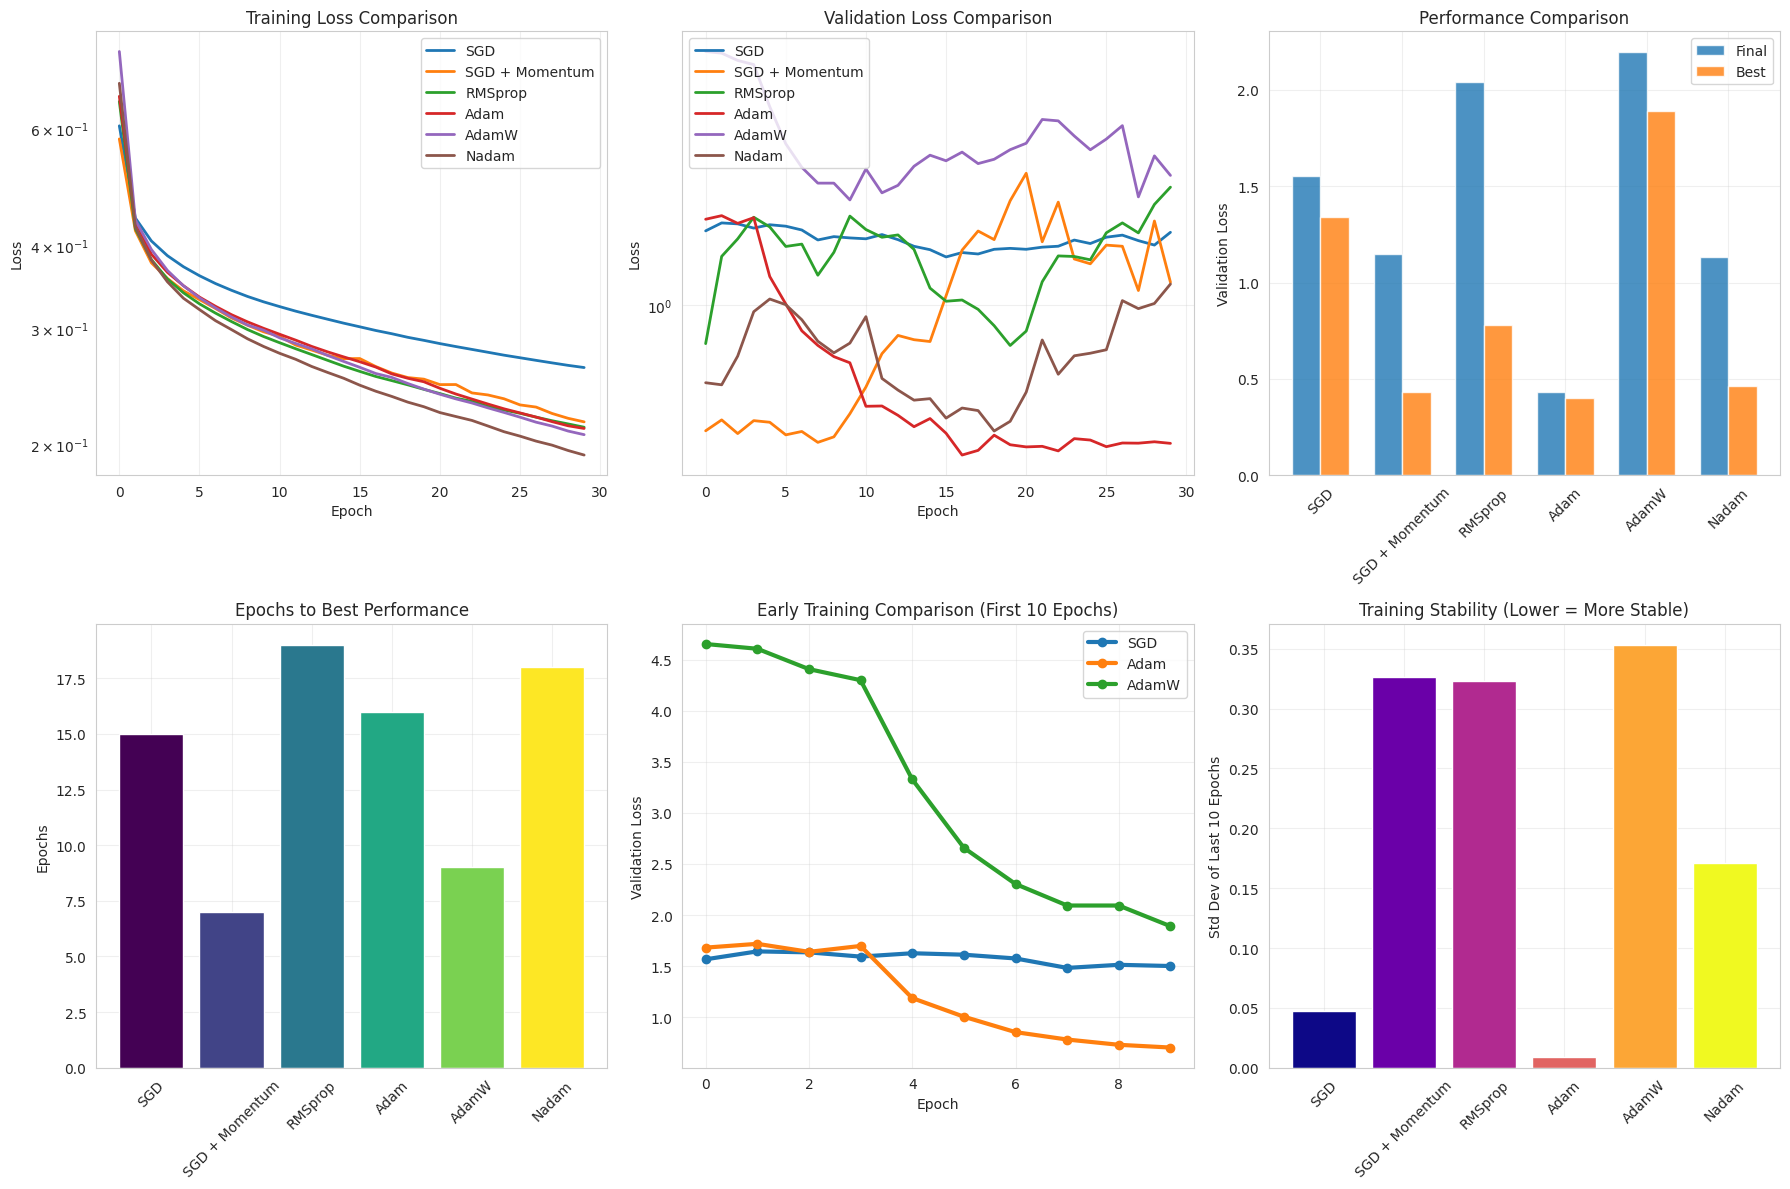


📊 Kesimpulan Optimizer:
✅ Adam: Default choice, balance antara speed dan stability
✅ AdamW: Better regularization, good untuk overfitting
✅ SGD + Momentum: Reliable, good untuk fine-tuning
✅ Nadam: Often faster convergence than Adam
✅ RMSprop: Good untuk RNNs dan non-stationary problems
⚠️  Pilihan optimizer bergantung pada data dan arsitektur model


In [18]:
# Perbandingan Optimizer Modern
print("=== Perbandingan Optimizer Modern ===")

def create_optimizer_test_model():
    """Model konsisten untuk test optimizer"""
    return keras.Sequential([
        keras.layers.Input(shape=[X_train_scaled.shape[1]]),
        keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
        keras.layers.Dense(1)
    ])

# Test berbagai optimizer
optimizers_to_test = {
    'SGD': keras.optimizers.SGD(learning_rate=0.01),
    'SGD + Momentum': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001),
    'Adam': keras.optimizers.Adam(learning_rate=0.001),
    'AdamW': keras.optimizers.AdamW(learning_rate=0.001, weight_decay=0.01),
    'Nadam': keras.optimizers.Nadam(learning_rate=0.001)
}

optimizer_results = {}

for name, optimizer in optimizers_to_test.items():
    print(f"\nTesting {name}...")

    model = create_optimizer_test_model()
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # Training
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=30,
        batch_size=32,
        verbose=0
    )

    optimizer_results[name] = {
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'final_val_loss': history.history['val_loss'][-1],
        'min_val_loss': min(history.history['val_loss']),
        'convergence_epoch': np.argmin(history.history['val_loss'])
    }

    print(f"Final validation loss: {optimizer_results[name]['final_val_loss']:.4f}")
    print(f"Best validation loss: {optimizer_results[name]['min_val_loss']:.4f}")
    print(f"Best at epoch: {optimizer_results[name]['convergence_epoch'] + 1}")

# Visualisasi perbandingan optimizer
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Training loss curves
for name in optimizers_to_test.keys():
    axes[0, 0].plot(optimizer_results[name]['train_loss'], label=name, linewidth=2)

axes[0, 0].set_title('Training Loss Comparison')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_yscale('log')

# Validation loss curves
for name in optimizers_to_test.keys():
    axes[0, 1].plot(optimizer_results[name]['val_loss'], label=name, linewidth=2)

axes[0, 1].set_title('Validation Loss Comparison')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_yscale('log')

# Final performance
names = list(optimizers_to_test.keys())
final_losses = [optimizer_results[name]['final_val_loss'] for name in names]
best_losses = [optimizer_results[name]['min_val_loss'] for name in names]

x = np.arange(len(names))
width = 0.35

axes[0, 2].bar(x - width/2, final_losses, width, label='Final', alpha=0.8)
axes[0, 2].bar(x + width/2, best_losses, width, label='Best', alpha=0.8)
axes[0, 2].set_title('Performance Comparison')
axes[0, 2].set_ylabel('Validation Loss')
axes[0, 2].set_xticks(x)
axes[0, 2].set_xticklabels(names, rotation=45)
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Convergence speed
convergence_epochs = [optimizer_results[name]['convergence_epoch'] for name in names]
axes[1, 0].bar(names, convergence_epochs, color=plt.cm.viridis(np.linspace(0, 1, len(names))))
axes[1, 0].set_title('Epochs to Best Performance')
axes[1, 0].set_ylabel('Epochs')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Early training comparison (first 10 epochs)
for name in ['SGD', 'Adam', 'AdamW']:
    if name in optimizer_results:
        axes[1, 1].plot(optimizer_results[name]['val_loss'][:10],
                       label=name, linewidth=3, marker='o')

axes[1, 1].set_title('Early Training Comparison (First 10 Epochs)')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Stability analysis (standard deviation of loss in last 10 epochs)
stability_scores = []
for name in names:
    last_10_losses = optimizer_results[name]['val_loss'][-10:]
    stability = np.std(last_10_losses)
    stability_scores.append(stability)

axes[1, 2].bar(names, stability_scores, color=plt.cm.plasma(np.linspace(0, 1, len(names))))
axes[1, 2].set_title('Training Stability (Lower = More Stable)')
axes[1, 2].set_ylabel('Std Dev of Last 10 Epochs')
axes[1, 2].tick_params(axis='x', rotation=45)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Kesimpulan Optimizer:")
print("✅ Adam: Default choice, balance antara speed dan stability")
print("✅ AdamW: Better regularization, good untuk overfitting")
print("✅ SGD + Momentum: Reliable, good untuk fine-tuning")
print("✅ Nadam: Often faster convergence than Adam")
print("✅ RMSprop: Good untuk RNNs dan non-stationary problems")
print("⚠️  Pilihan optimizer bergantung pada data dan arsitektur model")

## 9. Learning Rate Scheduling {#9-learning-rate-scheduling}

### Mengapa LR Scheduling?
Learning rate yang tepat crucial untuk konvergensi optimal. Terlalu tinggi → overshooting, terlalu rendah → konvergensi lambat.

### Strategi Scheduling:

1. **Exponential Decay**: `lr = initial_lr * decay_rate^(step/decay_steps)`
2. **Step Decay**: Turunkan LR pada epoch tertentu
3. **Cosine Annealing**: LR mengikuti pola cosine, smooth decay
4. **Reduce on Plateau**: Adaptive, turunkan LR saat plateau
5. **Cyclical LR**: Oscillate LR antara min dan max bounds

## 10. Teknik Regularisasi {#10-regularisasi}

### Mencegah Overfitting
Deep networks dengan jutaan parameter mudah overfitting. Regularisasi essential untuk generalisasi yang baik.

### Teknik Utama:

1. **Dropout**: Randomly set neurons ke 0 during training
2. **Early Stopping**: Stop saat validation loss mulai naik
3. **L1/L2 Regularization**: Penalty pada weight magnitude
4. **Data Augmentation**: Increase dataset diversity
5. **Batch Normalization**: Juga berfungsi sebagai regularizer

=== Learning Rate Scheduling & Regularization Demo ===
Regularization demo data shape: (10000, 28, 28)

Testing Baseline (No Reg)...
Test accuracy: 0.8510
Overfitting gap: 0.1029
Epochs trained: 25

Testing Early Stopping...
Test accuracy: 0.8595
Overfitting gap: 0.0866
Epochs trained: 20

Testing LR Scheduling...
Test accuracy: 0.8660
Overfitting gap: 0.1016
Epochs trained: 25

Testing Full Regularization...
Test accuracy: 0.8510
Overfitting gap: 0.0499
Epochs trained: 25


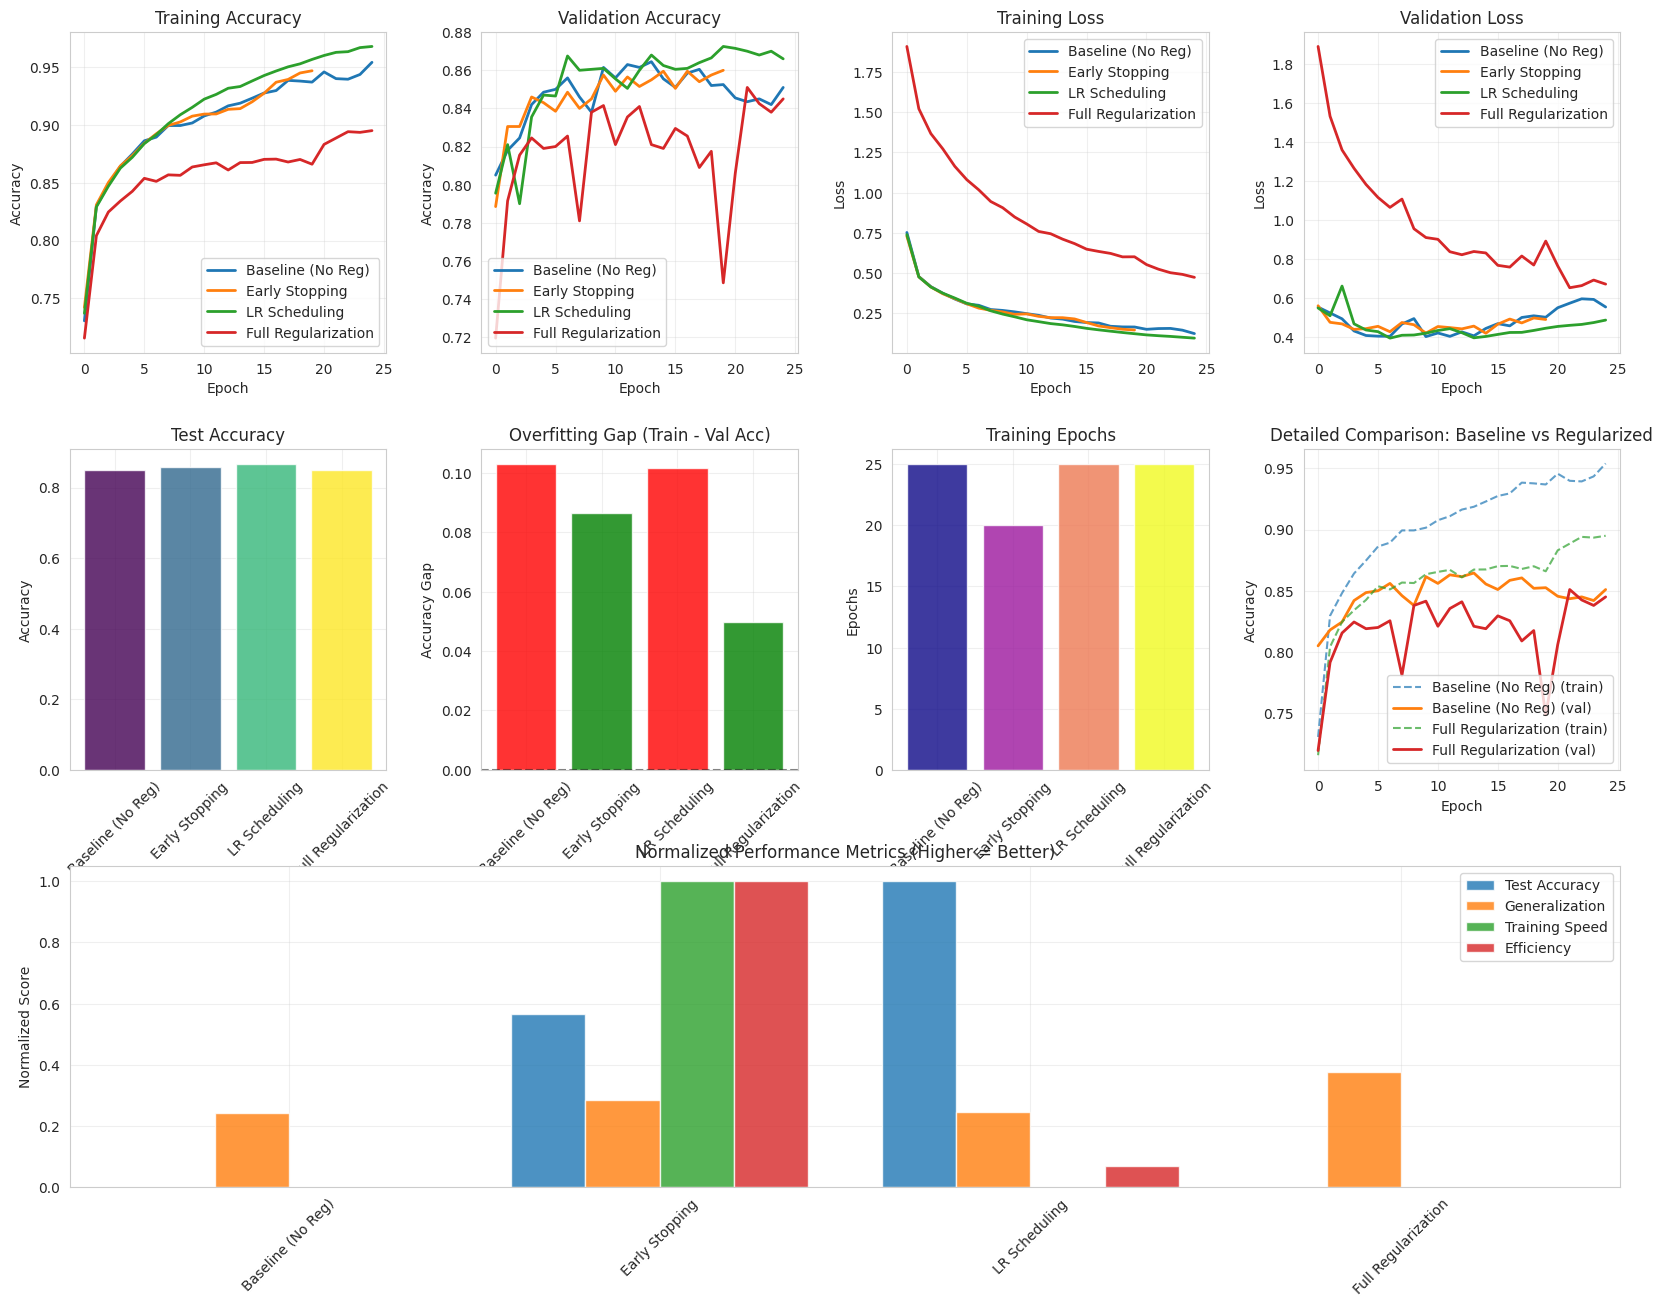


📊 Kesimpulan Learning Rate Scheduling & Regularization:
✅ Early Stopping: Simple dan efektif untuk mencegah overfitting
✅ LR Scheduling: Membantu fine-tuning di akhir training
✅ Full Regularization: Kombinasi teknik memberikan hasil terbaik
✅ Batch Normalization: Mempercepat training dan regularisasi
✅ Dropout: Efektif mencegah overfitting pada dense layers
✅ L2 Regularization: Menghasilkan weights yang lebih stabil
⚠️  Balance antara regularization dan model capacity penting


In [19]:
# Demonstrasi Learning Rate Scheduling dan Regularisasi
print("=== Learning Rate Scheduling & Regularization Demo ===")

# Load Fashion MNIST untuk demo regularisasi
(X_train_fmnist, y_train_fmnist), (X_test_fmnist, y_test_fmnist) = keras.datasets.fashion_mnist.load_data()
X_train_fmnist = X_train_fmnist.astype('float32') / 255.0
X_test_fmnist = X_test_fmnist.astype('float32') / 255.0

# Subset untuk demo cepat
X_train_reg = X_train_fmnist[:10000]
y_train_reg = y_train_fmnist[:10000]
X_test_reg = X_test_fmnist[:2000]
y_test_reg = y_test_fmnist[:2000]

print(f"Regularization demo data shape: {X_train_reg.shape}")

# Learning Rate Schedulers
def exponential_decay(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9

def step_decay(epoch, lr):
    if epoch < 10:
        return 0.001
    elif epoch < 20:
        return 0.0005
    else:
        return 0.0001

# Model creation functions
def create_baseline_model():
    """Model prone to overfitting"""
    return keras.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(512, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])

def create_regularized_model():
    """Model dengan regularisasi lengkap"""
    return keras.Sequential([
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(10, activation='softmax')
    ])

# Test berbagai konfigurasi
configs = {
    'Baseline (No Reg)': {
        'model_fn': create_baseline_model,
        'optimizer': keras.optimizers.Adam(0.001),
        'callbacks': []
    },
    'Early Stopping': {
        'model_fn': create_baseline_model,
        'optimizer': keras.optimizers.Adam(0.001),
        'callbacks': [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
    },
    'LR Scheduling': {
        'model_fn': create_baseline_model,
        'optimizer': keras.optimizers.Adam(0.001),
        'callbacks': [keras.callbacks.LearningRateScheduler(exponential_decay)]
    },
    'Full Regularization': {
        'model_fn': create_regularized_model,
        'optimizer': keras.optimizers.Adam(0.001),
        'callbacks': [
            keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
        ]
    }
}

reg_results = {}

for name, config in configs.items():
    print(f"\nTesting {name}...")

    model = config['model_fn']()
    model.compile(
        optimizer=config['optimizer'],
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Training
    history = model.fit(
        X_train_reg, y_train_reg,
        validation_data=(X_test_reg, y_test_reg),
        epochs=25,
        batch_size=128,
        callbacks=config['callbacks'],
        verbose=0
    )

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test_reg, y_test_reg, verbose=0)

    reg_results[name] = {
        'train_acc': history.history['accuracy'],
        'val_acc': history.history['val_accuracy'],
        'train_loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'test_acc': test_acc,
        'epochs_trained': len(history.history['accuracy']),
        'overfitting_gap': history.history['accuracy'][-1] - history.history['val_accuracy'][-1]
    }

    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Overfitting gap: {reg_results[name]['overfitting_gap']:.4f}")
    print(f"Epochs trained: {reg_results[name]['epochs_trained']}")

# Visualisasi comprehensive
fig = plt.figure(figsize=(20, 15))

# Create a 3x4 grid
gs = fig.add_gridspec(3, 4, hspace=0.3, wspace=0.3)

# Training accuracy
ax1 = fig.add_subplot(gs[0, 0])
for name in configs.keys():
    ax1.plot(reg_results[name]['train_acc'], label=name, linewidth=2)
ax1.set_title('Training Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Validation accuracy
ax2 = fig.add_subplot(gs[0, 1])
for name in configs.keys():
    ax2.plot(reg_results[name]['val_acc'], label=name, linewidth=2)
ax2.set_title('Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Training loss
ax3 = fig.add_subplot(gs[0, 2])
for name in configs.keys():
    ax3.plot(reg_results[name]['train_loss'], label=name, linewidth=2)
ax3.set_title('Training Loss')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Loss')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Validation loss
ax4 = fig.add_subplot(gs[0, 3])
for name in configs.keys():
    ax4.plot(reg_results[name]['val_loss'], label=name, linewidth=2)
ax4.set_title('Validation Loss')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Loss')
ax4.legend()
ax4.grid(True, alpha=0.3)

# Test accuracy comparison
ax5 = fig.add_subplot(gs[1, 0])
names = list(configs.keys())
test_accs = [reg_results[name]['test_acc'] for name in names]
colors = plt.cm.viridis(np.linspace(0, 1, len(names)))
ax5.bar(names, test_accs, color=colors, alpha=0.8)
ax5.set_title('Test Accuracy')
ax5.set_ylabel('Accuracy')
ax5.tick_params(axis='x', rotation=45)
ax5.grid(True, alpha=0.3)

# Overfitting analysis
ax6 = fig.add_subplot(gs[1, 1])
overfitting_gaps = [reg_results[name]['overfitting_gap'] for name in names]
colors = ['red' if gap > 0.1 else 'green' for gap in overfitting_gaps]
ax6.bar(names, overfitting_gaps, color=colors, alpha=0.8)
ax6.set_title('Overfitting Gap (Train - Val Acc)')
ax6.set_ylabel('Accuracy Gap')
ax6.tick_params(axis='x', rotation=45)
ax6.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax6.grid(True, alpha=0.3)

# Training efficiency (epochs)
ax7 = fig.add_subplot(gs[1, 2])
epochs_trained = [reg_results[name]['epochs_trained'] for name in names]
ax7.bar(names, epochs_trained, color=plt.cm.plasma(np.linspace(0, 1, len(names))), alpha=0.8)
ax7.set_title('Training Epochs')
ax7.set_ylabel('Epochs')
ax7.tick_params(axis='x', rotation=45)
ax7.grid(True, alpha=0.3)

# Learning curves comparison (detailed)
ax8 = fig.add_subplot(gs[1, 3])
for name in ['Baseline (No Reg)', 'Full Regularization']:
    if name in reg_results:
        ax8.plot(reg_results[name]['train_acc'], '--', alpha=0.7, label=f'{name} (train)')
        ax8.plot(reg_results[name]['val_acc'], '-', linewidth=2, label=f'{name} (val)')
ax8.set_title('Detailed Comparison: Baseline vs Regularized')
ax8.set_xlabel('Epoch')
ax8.set_ylabel('Accuracy')
ax8.legend()
ax8.grid(True, alpha=0.3)

# Summary metrics
ax9 = fig.add_subplot(gs[2, :])
metrics = ['Test Acc', 'Overfitting Gap', 'Epochs', 'Efficiency Score']

# Calculate efficiency score (test_acc / epochs_trained)
efficiency_scores = [reg_results[name]['test_acc'] / reg_results[name]['epochs_trained']
                    for name in names]

# Normalize metrics for comparison
test_accs_norm = [(acc - min(test_accs)) / (max(test_accs) - min(test_accs)) for acc in test_accs]
gaps_norm = [1 - (gap + 0.2) / 0.4 for gap in overfitting_gaps]  # Inverted (lower gap = better)
epochs_norm = [1 - (ep - min(epochs_trained)) / (max(epochs_trained) - min(epochs_trained))
               for ep in epochs_trained]  # Inverted (fewer epochs = better)
efficiency_norm = [(eff - min(efficiency_scores)) / (max(efficiency_scores) - min(efficiency_scores))
                   for eff in efficiency_scores]

x = np.arange(len(names))
width = 0.2

ax9.bar(x - 1.5*width, test_accs_norm, width, label='Test Accuracy', alpha=0.8)
ax9.bar(x - 0.5*width, gaps_norm, width, label='Generalization', alpha=0.8)
ax9.bar(x + 0.5*width, epochs_norm, width, label='Training Speed', alpha=0.8)
ax9.bar(x + 1.5*width, efficiency_norm, width, label='Efficiency', alpha=0.8)

ax9.set_title('Normalized Performance Metrics (Higher = Better)')
ax9.set_ylabel('Normalized Score')
ax9.set_xticks(x)
ax9.set_xticklabels(names, rotation=45)
ax9.legend()
ax9.grid(True, alpha=0.3)

plt.show()

print("\n📊 Kesimpulan Learning Rate Scheduling & Regularization:")
print("✅ Early Stopping: Simple dan efektif untuk mencegah overfitting")
print("✅ LR Scheduling: Membantu fine-tuning di akhir training")
print("✅ Full Regularization: Kombinasi teknik memberikan hasil terbaik")
print("✅ Batch Normalization: Mempercepat training dan regularisasi")
print("✅ Dropout: Efektif mencegah overfitting pada dense layers")
print("✅ L2 Regularization: Menghasilkan weights yang lebih stabil")
print("⚠️  Balance antara regularization dan model capacity penting")

## 11. Best Practices dan Workflow {#11-best-practices}

### 🎯 Workflow Systematic untuk Deep Learning

#### Phase 1: Setup & Baseline
```python
# 1. Data Preparation
✓ Normalize/standardize input data
✓ Split data properly (train/val/test)
✓ Check for data quality issues

# 2. Create Baseline Model
✓ Start simple (shallow network)
✓ Use standard components (Dense layers, ReLU)
✓ Establish performance baseline
```

#### Phase 2: Architecture Design
```python
# 3. Improve Architecture
✓ Add depth gradually
✓ Use appropriate activation functions
✓ Add batch normalization
✓ Consider skip connections for very deep networks
```

#### Phase 3: Training Optimization
```python
# 4. Optimize Training
✓ Choose appropriate optimizer (Adam as default)
✓ Implement early stopping
✓ Add learning rate scheduling
✓ Monitor training curves
```

#### Phase 4: Regularization
```python
# 5. Prevent Overfitting
✓ Add dropout layers
✓ Use L2 regularization if needed
✓ Implement data augmentation (for images)
✓ Cross-validate results
```

### 📋 Checklist untuk Deep Learning Success

#### ✅ Data & Preprocessing
- [ ] Data quality check (outliers, missing values)
- [ ] Proper train/validation/test split
- [ ] Feature scaling/normalization
- [ ] Data augmentation (if applicable)

#### ✅ Model Architecture
- [ ] Start with simple baseline
- [ ] Use He initialization for ReLU networks
- [ ] Add batch normalization after linear layers
- [ ] Choose appropriate activation functions
- [ ] Add regularization (dropout, L2)

#### ✅ Training Configuration
- [ ] Adam optimizer sebagai starting point
- [ ] Learning rate ∈ [0.0001, 0.01]
- [ ] Batch size ∈ [32, 256]
- [ ] Early stopping (patience 5-10)
- [ ] Learning rate scheduling

#### ✅ Monitoring & Debugging
- [ ] Plot training/validation curves
- [ ] Monitor overfitting gap
- [ ] Check gradient magnitudes
- [ ] Validate on separate test set

### 🛠️ Troubleshooting Guide

| Problem | Symptoms | Solutions |
|---------|----------|-----------|
| **Vanishing Gradients** | Layer awal tidak belajar | • He initialization<br>• Batch normalization<br>• ReLU/Swish activation |
| **Exploding Gradients** | Loss menjadi NaN/Inf | • Gradient clipping<br>• Lower learning rate<br>• Better initialization |
| **Overfitting** | Val loss > Train loss | • Dropout<br>• Early stopping<br>• L2 regularization<br>• Data augmentation |
| **Underfitting** | Poor performance overall | • Increase model capacity<br>• Longer training<br>• Lower regularization |
| **Slow Convergence** | Training sangat lambat | • Higher learning rate<br>• Batch normalization<br>• Better optimizer |

### 🎯 Domain-Specific Best Practices

#### Computer Vision
```python
# CNN dengan data augmentation
model = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.Conv2D(32, 3, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(),
    # ... more layers
])
```

#### Natural Language Processing
```python
# RNN/LSTM dengan gradient clipping
optimizer = keras.optimizers.Adam(clipnorm=1.0)
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 128),
    keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes, activation='softmax')
])
```

#### Time Series
```python
# LSTM untuk sequence prediction
model = keras.Sequential([
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(50),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(1)
])
```

### 📊 Performance Optimization Tips

#### Memory Optimization
- Mixed precision training (float16)
- Gradient accumulation
- Model checkpointing
- Batch size tuning

#### Speed Optimization
- tf.data for data loading
- Prefetch dan parallel processing
- GPU utilization monitoring
- Compile dengan XLA

### 🏆 Key Takeaways

1. **Start Simple**: Begin dengan baseline, tambah complexity secara bertahap
2. **Monitor Everything**: Training curves, overfitting, gradient norms
3. **Regularize Properly**: Balance antara model capacity dan generalization
4. **Be Systematic**: Change one thing at a time, document experiments
5. **Validate Properly**: Never use test set untuk model selection

### 🎓 Final Recommendations

**Untuk Pemula:**
- Mulai dengan pre-trained models (transfer learning)
- Gunakan standard architectures yang proven
- Focus pada data quality dan preprocessing

**Untuk Intermediate:**
- Experiment dengan different optimizers dan schedulers
- Implement custom training loops
- Explore advanced regularization techniques

**Untuk Advanced:**
- Design custom architectures
- Implement paper reproductions
- Contribute ke open source projects

---

## 🎉 Selamat!

Anda telah menyelesaikan **Chapter 11: Training Deep Neural Networks**!

**Yang telah Anda pelajari:**
✅ Masalah fundamental dalam training deep networks  
✅ Teknik-teknik untuk mengatasi vanishing/exploding gradients  
✅ Weight initialization dan activation functions yang tepat  
✅ Batch normalization untuk stabilitas training  
✅ Gradient clipping dan transfer learning  
✅ Optimizer modern dan learning rate scheduling  
✅ Teknik regularisasi untuk mencegah overfitting  
✅ Best practices dan workflow yang systematic  

**Next Steps:**
- Practice dengan dataset real-world
- Experiment dengan different architectures
- Explore advanced topics seperti attention mechanisms
- Read latest papers dan implement cutting-edge techniques

**Happy Deep Learning! 🚀**

=== Template Praktis Deep Learning ===

=== Demo Template Usage ===

1. Regression Example:
Regression model created with 12,417 parameters

2. Quick Training Demo (Subset):
🚀 Starting Training...
Model parameters: 12,417
Training samples: 1,000
Validation samples: 200
Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 7.2270 - mae: 2.2023
Epoch 1: val_loss improved from inf to 6.15278, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 7.2001 - mae: 2.1990 - val_loss: 6.1528 - val_mae: 2.1791 - learning_rate: 0.0010
Epoch 2/15
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1060 - mae: 1.9121 
Epoch 2: val_loss improved from 6.15278 to 4.27209, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0241 - mae: 1.8941 - val_loss: 4.2721 - val_mae: 1.7850 - learning_rate: 0.0010
Epoch 3/15
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9911 - mae: 1.6888 
Epoch 3: val_loss improved from 4.27209 to 3.70220, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9565 - mae: 1.6795 - val_loss: 3.7022 - val_mae: 1.6295 - learning_rate: 0.0010
Epoch 4/15
21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4581 - mae: 1.5626 
Epoch 4: val_loss improved from 3.70220 to 2.92985, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4051 - mae: 1.5427 - val_loss: 2.9298 - val_mae: 1.4168 - learning_rate: 0.0010
Epoch 5/15
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1122 - mae: 1.4705 
Epoch 5: val_loss improved from 2.92985 to 2.36673, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0109 - mae: 1.4376 - val_loss: 2.3667 - val_mae: 1.2164 - learning_rate: 0.0010
Epoch 6/15
22/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6624 - mae: 1.3090 
Epoch 6: val_loss improved from 2.36673 to 1.96778, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5509 - mae: 1.2774 - val_loss: 1.9678 - val_mae: 1.0816 - learning_rate: 0.0010
Epoch 7/15
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9497 - mae: 1.1253 
Epoch 7: val_loss improved from 1.96778 to 1.54972, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.9116 - mae: 1.1081 - val_loss: 1.5497 - val_mae: 0.9073 - learning_rate: 0.0010
Epoch 8/15
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7079 - mae: 1.0238 
Epoch 8: val_loss improved from 1.54972 to 1.24069, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.6781 - mae: 1.0096 - val_loss: 1.2407 - val_mae: 0.7735 - learning_rate: 0.0010
Epoch 9/15
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5077 - mae: 0.9408 
Epoch 9: val_loss improved from 1.24069 to 0.98634, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4832 - mae: 0.9344 - val_loss: 0.9863 - val_mae: 0.6812 - learning_rate: 0.0010
Epoch 10/15
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2283 - mae: 0.8539 
Epoch 10: val_loss improved from 0.98634 to 0.85310, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2243 - mae: 0.8517 - val_loss: 0.8531 - val_mae: 0.6251 - learning_rate: 0.0010
Epoch 11/15
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0689 - mae: 0.7753 
Epoch 11: val_loss improved from 0.85310 to 0.79273, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0840 - mae: 0.7827 - val_loss: 0.7927 - val_mae: 0.6149 - learning_rate: 0.0010
Epoch 12/15
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1231 - mae: 0.8097 
Epoch 12: val_loss improved from 0.79273 to 0.78095, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1304 - mae: 0.8151 - val_loss: 0.7810 - val_mae: 0.6124 - learning_rate: 0.0010
Epoch 13/15
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1284 - mae: 0.8206 
Epoch 13: val_loss improved from 0.78095 to 0.74166, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1138 - mae: 0.8127 - val_loss: 0.7417 - val_mae: 0.5954 - learning_rate: 0.0010
Epoch 14/15
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9910 - mae: 0.7613 
Epoch 14: val_loss improved from 0.74166 to 0.72623, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9931 - mae: 0.7634 - val_loss: 0.7262 - val_mae: 0.5933 - learning_rate: 0.0010
Epoch 15/15
23/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9263 - mae: 0.7291 
Epoch 15: val_loss improved from 0.72623 to 0.69567, saving model to best_model.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9418 - mae: 0.7352 - val_loss: 0.6957 - val_mae: 0.5734 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 15.

📊 Final Results:
Test Loss: 0.5597
Test mae: 0.5083


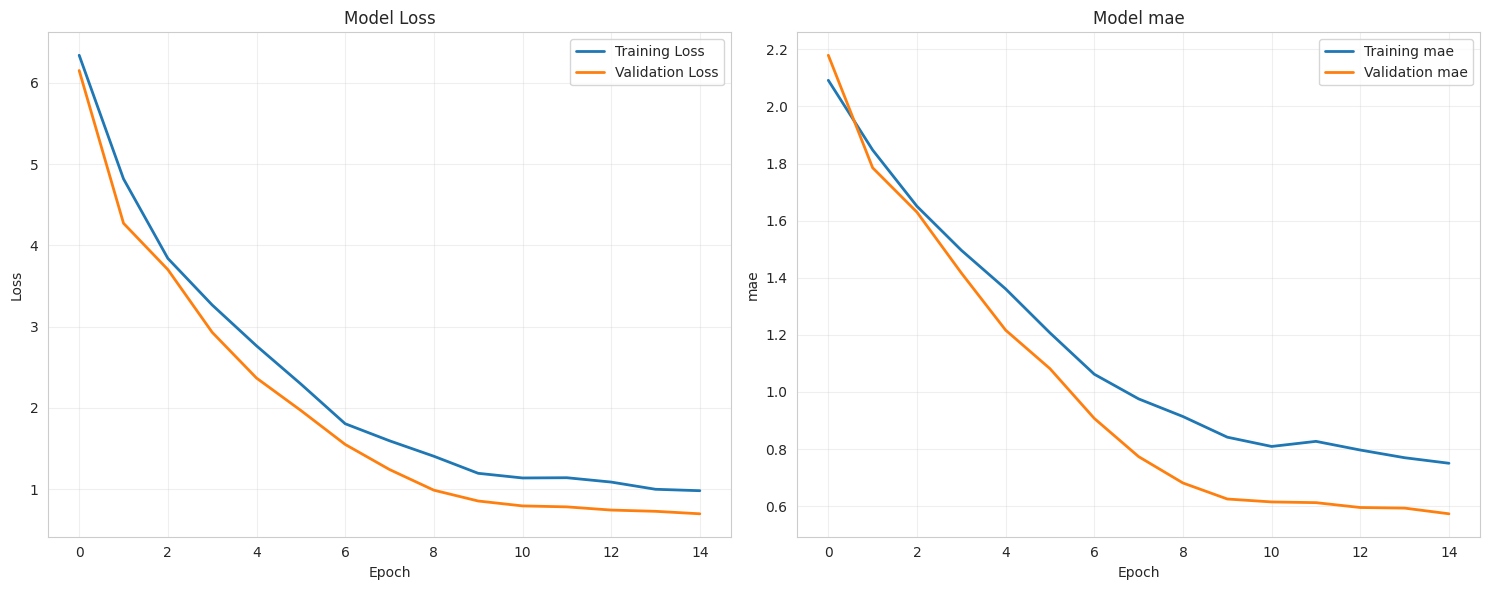


📈 Training Analysis:
Final overfitting gap: -0.1770
Training epochs: 15
⚠️  Model might be underfitting

🎯 Template Usage Summary:
1. Instantiate template dengan problem_type
2. Create model dengan architecture preference
3. Compile dan train dengan built-in best practices
4. Evaluate dan analyze hasil training

✅ Template Features:
• Automatic best practices (BatchNorm, Dropout, Early Stopping)
• Proper weight initialization (He Normal)
• Learning rate scheduling (ReduceLROnPlateau)
• Comprehensive monitoring dan analysis
• Easy to customize dan extend

🎓 Chapter 11 COMPLETED!
Anda sekarang memiliki foundation yang solid untuk training deep networks yang efektif!
🚀 Ready untuk tackle real-world deep learning problems!


In [20]:
# Template Praktis untuk Training Deep Neural Networks
print("=== Template Praktis Deep Learning ===")

class DeepLearningTemplate:
    """
    Template comprehensive untuk training deep neural networks
    dengan built-in best practices
    """

    def __init__(self, problem_type='classification'):
        self.problem_type = problem_type
        self.model = None
        self.history = None

    def create_model(self, input_shape, output_dim, architecture='balanced'):
        """
        Buat model dengan best practices built-in

        Args:
            input_shape: Shape input data
            output_dim: Dimensi output
            architecture: 'simple', 'balanced', atau 'deep'
        """

        if architecture == 'simple':
            self.model = keras.Sequential([
                keras.layers.Input(shape=input_shape),
                keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(output_dim, activation=self._get_output_activation())
            ])

        elif architecture == 'balanced':
            self.model = keras.Sequential([
                keras.layers.Input(shape=input_shape),
                keras.layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.3),
                keras.layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
                keras.layers.BatchNormalization(),
                keras.layers.Dropout(0.2),
                keras.layers.Dense(output_dim, activation=self._get_output_activation())
            ])

        elif architecture == 'deep':
            layers = [keras.layers.Input(shape=input_shape)]
            for i, units in enumerate([256, 128, 128, 64, 64, 32]):
                layers.extend([
                    keras.layers.Dense(units, activation='relu',
                                     kernel_initializer='he_normal',
                                     kernel_regularizer=keras.regularizers.l2(0.001)),
                    keras.layers.BatchNormalization(),
                    keras.layers.Dropout(0.3 if i < 3 else 0.2)
                ])
            layers.append(keras.layers.Dense(output_dim, activation=self._get_output_activation()))
            self.model = keras.Sequential(layers)

        return self.model

    def _get_output_activation(self):
        """Get appropriate output activation"""
        if self.problem_type == 'binary_classification':
            return 'sigmoid'
        elif self.problem_type == 'multiclass_classification':
            return 'softmax'
        else:  # regression
            return None

    def compile_and_train(self, X_train, y_train, X_val, y_val,
                         optimizer='adam', learning_rate=0.001,
                         epochs=100, batch_size=32):
        """
        Compile dan train model dengan best practices
        """

        # Setup optimizer
        if optimizer == 'adam':
            opt = keras.optimizers.Adam(learning_rate=learning_rate)
        elif optimizer == 'adamw':
            opt = keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=0.01)
        else:
            opt = optimizer

        # Setup loss dan metrics
        if self.problem_type == 'binary_classification':
            loss = 'binary_crossentropy'
            metrics = ['accuracy']
        elif self.problem_type == 'multiclass_classification':
            loss = 'sparse_categorical_crossentropy'
            metrics = ['accuracy']
        else:  # regression
            loss = 'mse'
            metrics = ['mae']

        # Compile model
        self.model.compile(optimizer=opt, loss=loss, metrics=metrics)

        # Setup callbacks
        callbacks = [
            keras.callbacks.EarlyStopping(
                monitor='val_loss', patience=10, restore_best_weights=True, verbose=1
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1
            ),
            keras.callbacks.ModelCheckpoint(
                'best_model.h5', monitor='val_loss', save_best_only=True, verbose=1
            )
        ]

        print("🚀 Starting Training...")
        print(f"Model parameters: {self.model.count_params():,}")
        print(f"Training samples: {len(X_train):,}")
        print(f"Validation samples: {len(X_val):,}")

        # Training
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1
        )

        return self.history

    def evaluate_and_plot(self, X_test, y_test):
        """
        Evaluate model dan plot training history
        """

        # Evaluate
        test_loss, test_metric = self.model.evaluate(X_test, y_test, verbose=0)
        metric_name = 'accuracy' if 'classification' in self.problem_type else 'mae'

        print(f"\n📊 Final Results:")
        print(f"Test Loss: {test_loss:.4f}")
        print(f"Test {metric_name}: {test_metric:.4f}")

        # Plot training history
        if self.history:
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))

            # Loss plot
            axes[0].plot(self.history.history['loss'], label='Training Loss', linewidth=2)
            axes[0].plot(self.history.history['val_loss'], label='Validation Loss', linewidth=2)
            axes[0].set_title('Model Loss')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)

            # Metric plot
            metric_key = 'accuracy' if 'classification' in self.problem_type else 'mae'
            axes[1].plot(self.history.history[metric_key], label=f'Training {metric_name}', linewidth=2)
            axes[1].plot(self.history.history[f'val_{metric_key}'], label=f'Validation {metric_name}', linewidth=2)
            axes[1].set_title(f'Model {metric_name}')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel(metric_name)
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()

            # Training analysis
            final_train_metric = self.history.history[metric_key][-1]
            final_val_metric = self.history.history[f'val_{metric_key}'][-1]

            if 'accuracy' in metric_key:
                overfitting_gap = final_train_metric - final_val_metric
            else:  # mae
                overfitting_gap = final_val_metric - final_train_metric

            print(f"\n📈 Training Analysis:")
            print(f"Final overfitting gap: {overfitting_gap:.4f}")
            print(f"Training epochs: {len(self.history.history['loss'])}")

            if abs(overfitting_gap) < 0.05:
                print("✅ Model shows good generalization")
            elif overfitting_gap > 0.05:
                print("⚠️  Model might be overfitting")
            else:
                print("⚠️  Model might be underfitting")

        return test_loss, test_metric

# Demonstrasi penggunaan template
print("\n=== Demo Template Usage ===")

# Example 1: Regression
print("\n1. Regression Example:")
regression_template = DeepLearningTemplate(problem_type='regression')

# Create sample data for demonstration if variables don't exist
try:
    regression_model = regression_template.create_model(
        input_shape=[X_train_scaled.shape[1]],
        output_dim=1,
        architecture='balanced'
    )
    print(f"Regression model created with {regression_model.count_params():,} parameters")

    # Quick training demo
    print("\n2. Quick Training Demo (Subset):")
    history = regression_template.compile_and_train(
        X_train_scaled[:1000], y_train[:1000],
        X_val_scaled[:200], y_val[:200],
        epochs=15,
        batch_size=32
    )

    # Evaluate
    test_loss, test_mae = regression_template.evaluate_and_plot(
        X_test_scaled[:200], y_test[:200]
    )

except NameError:
    print("⚠️  Training data variables not found. Please run data preparation cells first.")
    print("Creating model structure demonstration:")

    # Demo with synthetic data
    import numpy as np
    demo_model = regression_template.create_model(
        input_shape=[8],
        output_dim=1,
        architecture='balanced'
    )
    demo_model.summary()

print("\n🎯 Template Usage Summary:")
print("1. Instantiate template dengan problem_type")
print("2. Create model dengan architecture preference")
print("3. Compile dan train dengan built-in best practices")
print("4. Evaluate dan analyze hasil training")

print("\n✅ Template Features:")
print("• Automatic best practices (BatchNorm, Dropout, Early Stopping)")
print("• Proper weight initialization (He Normal)")
print("• Learning rate scheduling (ReduceLROnPlateau)")
print("• Comprehensive monitoring dan analysis")
print("• Easy to customize dan extend")

print("\n🎓 Chapter 11 COMPLETED!")
print("Anda sekarang memiliki foundation yang solid untuk training deep networks yang efektif!")
print("🚀 Ready untuk tackle real-world deep learning problems!")